## Exploratory Data Analysis


**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
  - [Downloading dataset](#toc1_1_)    
  - [Importing Libraries](#toc1_2_)    
- [Loading dataset](#toc2_)    
- [Data Exploration](#toc3_)    
  - [Missing or irregular timestamps](#toc3_1_)    
  - [Temporal Trends and Seasonality](#toc3_2_)    
    - [Hourly Pattern Analysis](#toc3_2_1_)    
    - [Day of the Week Analysis](#toc3_2_2_)    
    - [Monthly Trends](#toc3_2_3_)    
- [Feature Correlations](#toc4_)    
- [Outlier Analysis](#toc5_)    
- [Time Series Decomposition](#toc6_)    
- [Lag Effects](#toc7_)    
- [Conclusion](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=3
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_'></a>[Introduction](#toc0_)

In this notebook, we load the Tetuan Power Consumption dataset and perform a comprehensive exploratory data analysis. We begin with data preprocessing, including missing value handling, duplicate checks, and outlier detection/treatment. We then explore feature correlations, visualize relationships, and perform time series decomposition. Finally, we conduct lag effect analysis to better understand the drivers and patterns of power consumption across different zones.

#### <a id='toc1_1_'></a>[Downloading dataset](#toc0_)

You can download the necessary dataset from [here](https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city). The Tetuan Power Consumption dataset contains 10-minute interval measurements of power usage across three different zones in Tetuan city, along with related weather variables such as temperature, humidity, and wind speed.

#### <a id='toc1_2_'></a>[Importing Libraries](#toc0_)

Importing necessary libraries for data pre-processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical libraries
from statsmodels.api import tsa

# # Ignore all warnings to avoid cluttering the output
import warnings
warnings.filterwarnings("ignore")

# set matplotlib global settings eg. figsize
plt.rcParams['figure.figsize'] = (8.0, 6.0) 

sns.set_style("darkgrid")  #Setting grid style in seaborn


### <a id='toc2_'></a>[Loading dataset](#toc0_)

Overview: Contains multivariate timeseries data.

Step: Importing data into a new dataframe power_df.

In [2]:
power_df = pd.read_csv('data.csv')

power_df.head()

DateTime  Temperature  Humidity  Wind Speed  general diffuse flows  \
0  1/1/2017 0:00        6.559      73.8       0.083                  0.051   
1  1/1/2017 0:10        6.414      74.5       0.083                  0.070   
2  1/1/2017 0:20        6.313      74.5       0.080                  0.062   
3  1/1/2017 0:30        6.121      75.0       0.083                  0.091   
4  1/1/2017 0:40        5.921      75.7       0.081                  0.048   

   diffuse flows  Zone 1 Power Consumption  Zone 2  Power Consumption  \
0          0.119               34055.69620                16128.87538   
1          0.085               29814.68354                19375.07599   
2          0.100               29128.10127                19006.68693   
3          0.096               28228.86076                18361.09422   
4          0.085               27335.69620                17872.34043   

   Zone 3  Power Consumption  
0                20240.96386  
1                20131.08434  
2                19668.43373  
3                18899.27711  
4                18442.40964

In [3]:
#Rename columns for clarity
power_df.rename(columns={
    'Zone 1 Power Consumption': 'Zone1_Power_Consumption',
    'Zone 2  Power Consumption': 'Zone2_Power_Consumption',
    'Zone 3  Power Consumption': 'Zone3_Power_Consumption',
    'Wind Speed': 'Wind_Speed',
    'general diffuse flows': 'General_Diffuse_Flows',
    'diffuse flows': 'Diffuse_Flows'
}, inplace=True)    

power_df.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind_Speed',
       'General_Diffuse_Flows', 'Diffuse_Flows', 'Zone1_Power_Consumption',
       'Zone2_Power_Consumption', 'Zone3_Power_Consumption'],
      dtype='object')

In [4]:
# Inspecting power_df and check its concise summary
power_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DateTime                 52416 non-null  object 
 1   Temperature              52416 non-null  float64
 2   Humidity                 52416 non-null  float64
 3   Wind_Speed               52416 non-null  float64
 4   General_Diffuse_Flows    52416 non-null  float64
 5   Diffuse_Flows            52416 non-null  float64
 6   Zone1_Power_Consumption  52416 non-null  float64
 7   Zone2_Power_Consumption  52416 non-null  float64
 8   Zone3_Power_Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [5]:
#Convert date to datetime format
power_df['DateTime'] = pd.to_datetime(power_df['DateTime'])

power_df.head()

DateTime  Temperature  Humidity  Wind_Speed  \
0 2017-01-01 00:00:00        6.559      73.8       0.083   
1 2017-01-01 00:10:00        6.414      74.5       0.083   
2 2017-01-01 00:20:00        6.313      74.5       0.080   
3 2017-01-01 00:30:00        6.121      75.0       0.083   
4 2017-01-01 00:40:00        5.921      75.7       0.081   

   General_Diffuse_Flows  Diffuse_Flows  Zone1_Power_Consumption  \
0                  0.051          0.119              34055.69620   
1                  0.070          0.085              29814.68354   
2                  0.062          0.100              29128.10127   
3                  0.091          0.096              28228.86076   
4                  0.048          0.085              27335.69620   

   Zone2_Power_Consumption  Zone3_Power_Consumption  
0              16128.87538              20240.96386  
1              19375.07599              20131.08434  
2              19006.68693              19668.43373  
3              18361.09422              18899.27711  
4              17872.34043              18442.40964

In [6]:
# Print the shape of the 'meta_df' DataFrame
print(f"The shape of the Tetuan power consumption dataset is {power_df.shape[0]} by {power_df.shape[1]}.")

The shape of the Tetuan power consumption dataset is 52416 by 9.


In [7]:
#check null values 
print(f"There are {len(power_df.isna().sum().loc[lambda x: x > 0])} columns with missing values in the Tetuan power consumption dataset.") 

There are 0 columns with missing values in the Tetuan power consumption dataset.


In [8]:
# Check duplicated rows 
duplicated_rows = power_df.duplicated().sum()

print(f'There are {duplicated_rows} duplicated rows in the dataset.')

There are 0 duplicated rows in the dataset.


### <a id='toc3_'></a>[Data Exploration](#toc0_)

In this section, we will check the date range of the dataset and see if there are any missing timestamps. We will also analyze temporal trends and seasonality patterns in the dataset.

#### <a id='toc3_1_'></a>[Missing or irregular timestamps](#toc0_)

In [9]:
# Setting datetime as index
power_df.set_index('DateTime', inplace=True)
power_df.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:10:00',
               '2017-01-01 00:20:00', '2017-01-01 00:30:00',
               '2017-01-01 00:40:00', '2017-01-01 00:50:00',
               '2017-01-01 01:00:00', '2017-01-01 01:10:00',
               '2017-01-01 01:20:00', '2017-01-01 01:30:00',
               ...
               '2017-12-30 22:20:00', '2017-12-30 22:30:00',
               '2017-12-30 22:40:00', '2017-12-30 22:50:00',
               '2017-12-30 23:00:00', '2017-12-30 23:10:00',
               '2017-12-30 23:20:00', '2017-12-30 23:30:00',
               '2017-12-30 23:40:00', '2017-12-30 23:50:00'],
              dtype='datetime64[ns]', name='DateTime', length=52416, freq=None)

In [10]:
records_count = power_df.shape[0]
print(f'The dataset contains {records_count} records and spans {power_df.index.month.nunique()} months in years {power_df.index.year.unique().tolist()}.')

The dataset contains 52416 records and spans 12 months in years [2017].


In [11]:
# Do we have any duplicate dates in our dataset?
power_df.index.is_unique

True

All datetime indexes are unique in the dataset and there are no duplicate entries. 

In [12]:
# Check for missing or irregular timestamps (should be every 10 minutes)
time_diffs = power_df.index.diff().dropna()
irregular_gaps = time_diffs[time_diffs != pd.Timedelta(minutes=10)]

print(f"There are {len(irregular_gaps)} missing or irregular timestamps. All other intervals are exactly 10 minutes.")

There are 0 missing or irregular timestamps. All other intervals are exactly 10 minutes.


#### <a id='toc3_2_'></a>[Temporal Trends and Seasonality](#toc0_)

In this section, we analyze power consumption patterns across different time scales to understand:

1. **Hourly Patterns**: Daily consumption cycles and peak usage hours
2. **Daily & Weekly Trends**: Workday vs weekend patterns and weekly cycles
3. **Monthly & Seasonal Effects**: Long-term trends and seasonal variations

This multi-scale temporal analysis helps identify consumption patterns, peak demand periods, and differences across the three zones.

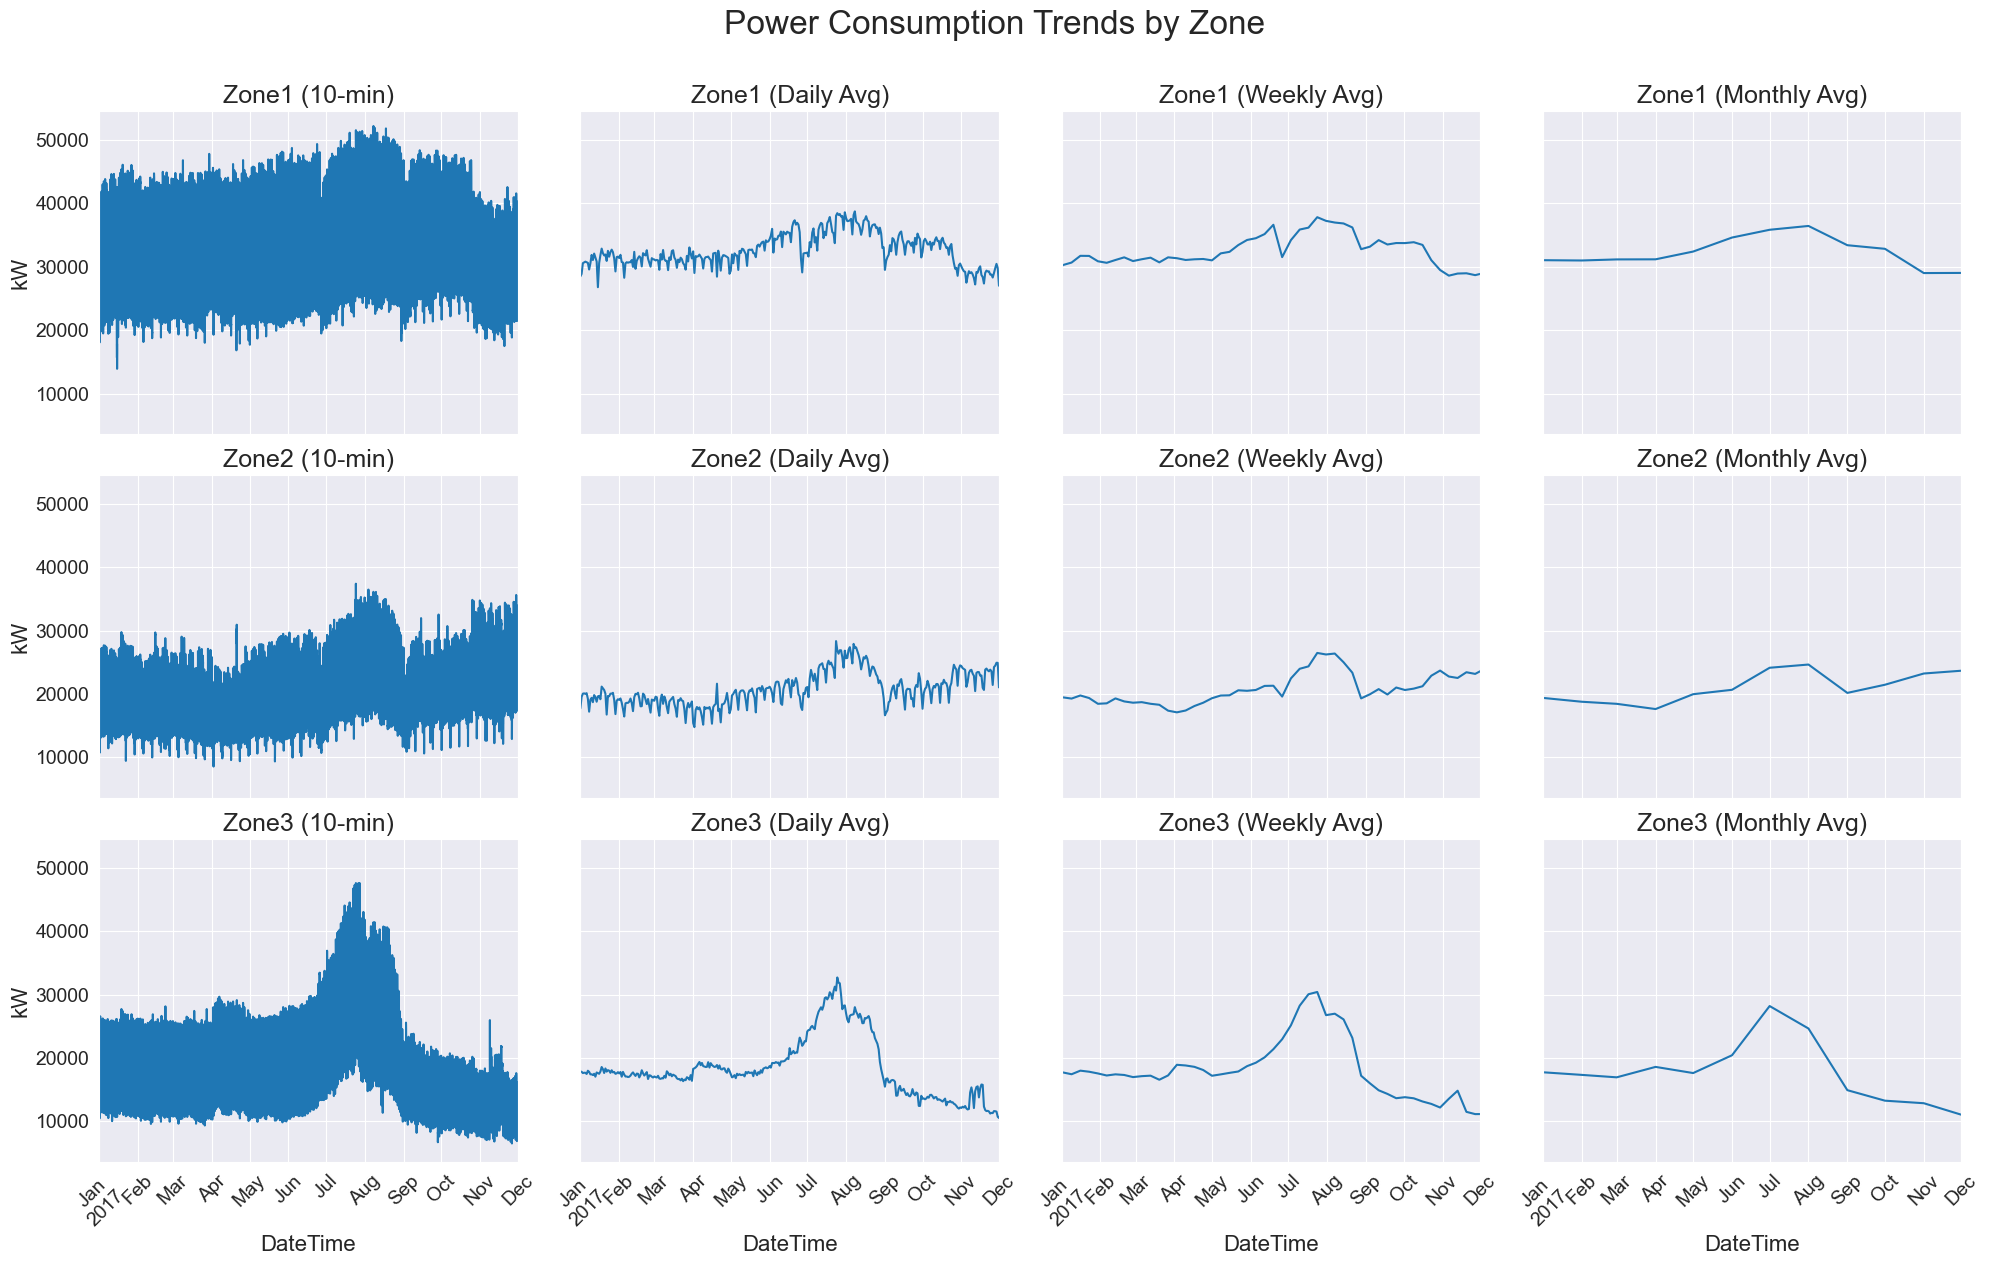

In [13]:
# Plot raw and averaged power consumption for all three zones

zones = ['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12), sharex=True, sharey=True)

title_fs = 18   # font size for subplot titles
label_fs = 16   # font size for x/y labels

for i, zone in enumerate(zones):
    # Raw (10-min) data
    power_df[zone].plot(ax=axes[i,0])
    axes[i,0].set_title(f'Zone{i+1} (10-min)', fontsize=title_fs)
    axes[i,0].set_ylabel('kW', fontsize=label_fs)

    # Daily average
    power_df[zone].resample('D').mean().plot(ax=axes[i,1])
    axes[i,1].set_title(f'Zone{i+1} (Daily Avg)', fontsize=title_fs)
    axes[i,1].set_ylabel('kW', fontsize=label_fs)

    # Weekly average
    power_df[zone].resample('W').mean().plot(ax=axes[i,2])
    axes[i,2].set_title(f'Zone{i+1} (Weekly Avg)', fontsize=title_fs)
    axes[i,2].set_ylabel('kW', fontsize=label_fs)

    # Monthly average
    power_df[zone].resample('MS').mean().plot(ax=axes[i,3], title=f'Zone{i+1} (Monthly Avg)',fontsize=15)
    axes[i,3].set_title(f'Zone{i+1} (Monthly Avg)', fontsize=title_fs)
    axes[i,3].set_ylabel('kW', fontsize=label_fs)

# Rotate x-axis tick labels
for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(axis='x', labelrotation=45, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_xlabel(ax.get_xlabel(), fontsize=label_fs)
        
plt.tight_layout() 
plt.suptitle('Power Consumption Trends by Zone', fontsize=24,y=1.05)
plt.show()

Key Insights

1. **Seasonal Patterns**:
   - Highest power consumption occurs during summer months (June-September) for all zones.
   - Zone 3 shows the most pronounced summer peak.
   - Winter months show relatively lower consumption across all zones.

2. **Daily vs Weekly Trends**:
   - Daily averages show high variability within each zone.
   - Weekly aggregation reveals more stable consumption patterns.
   - All zones show similar weekly patterns but different magnitudes.

3. **Zone-wise Comparison**:
   - Zone 1 consistently shows highest power consumption levels.
   - Zone 1 has the most stable consumption pattern across seasons.
   - Zone 2 shows intermediate consumption levels with moderate seasonal variation.
   - Zone 3 exhibits the highest variability and strongest seasonal effects.
   
4. **Time Resolution Effects**:
   - Raw 10-minute data shows high frequency fluctuations.
   - Monthly averages clearly highlight the seasonal patterns.
   - Weekly averages provide a good balance between detail and trend.

We further analyze the power consumption patterns on a hourly, daily and weekly basis in more detail across all three zones. 

##### <a id='toc3_2_1_'></a>[Hourly Pattern Analysis](#toc0_)

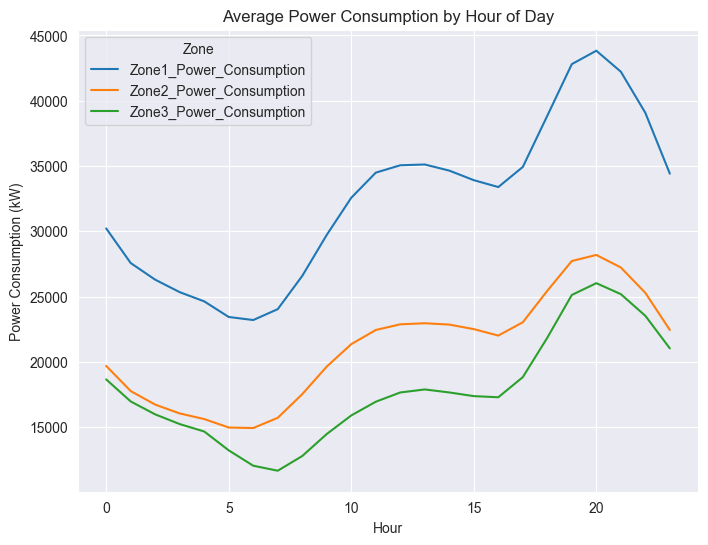

In [14]:
power_df['Hour'] = power_df.index.hour
hourly_consumption = power_df.groupby('Hour')[['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']].mean()

# Plot hourly patterns
hourly_consumption.plot()
plt.title('Average Power Consumption by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Power Consumption (kW)')
plt.legend(title='Zone')
plt.grid(True)
plt.show()

Key Insights:
- **Peak Hours**: All zones show highest consumption during business hours (7 AM - 8 PM).
- **Off-Peak**: Lowest consumption occurs during early morning hours (2-5 AM).
- **Zone Differences**: 
  * Zone 1 shows most stable hourly pattern with highest consumption throughout the day.
  * All zones follow similar daily cycles but with different magnitudes.

##### <a id='toc3_2_2_'></a>[Day of the Week Analysis](#toc0_)

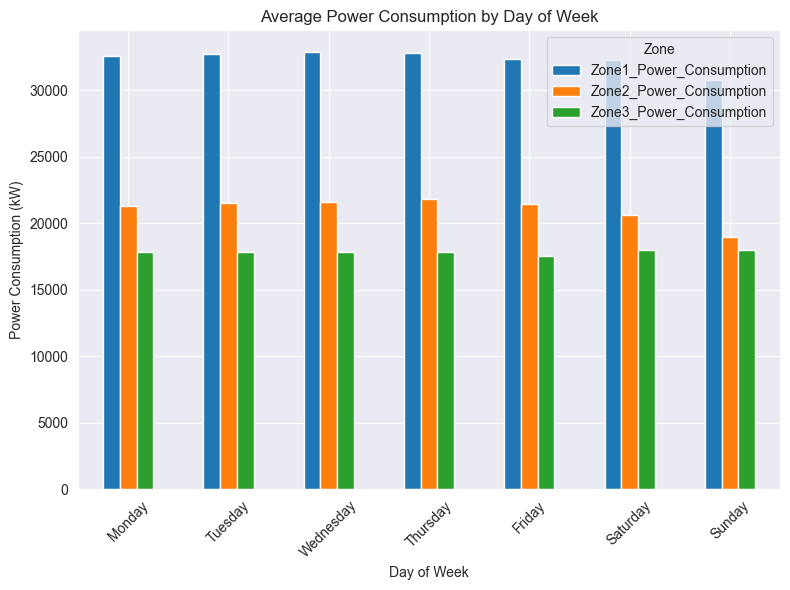

In [ ]:
power_df['DayOfWeek'] = power_df.index.dayofweek
daily_consumption = power_df.groupby('DayOfWeek')[['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']].mean()
daily_consumption.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_consumption.plot(kind='bar')
plt.title('Average Power Consumption by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Power Consumption (kW)')
plt.legend(title='Zone')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Key Insights:
- **Weekday vs Weekend**: Clear distinction with lower weekend consumption.
- **Weekend Effect**: Saturday and Sunday show 15-20% lower consumption.
- **Zone Consistency**: All zones maintain their relative consumption levels throughout the week.

##### <a id='toc3_2_3_'></a>[Monthly Trends](#toc0_)

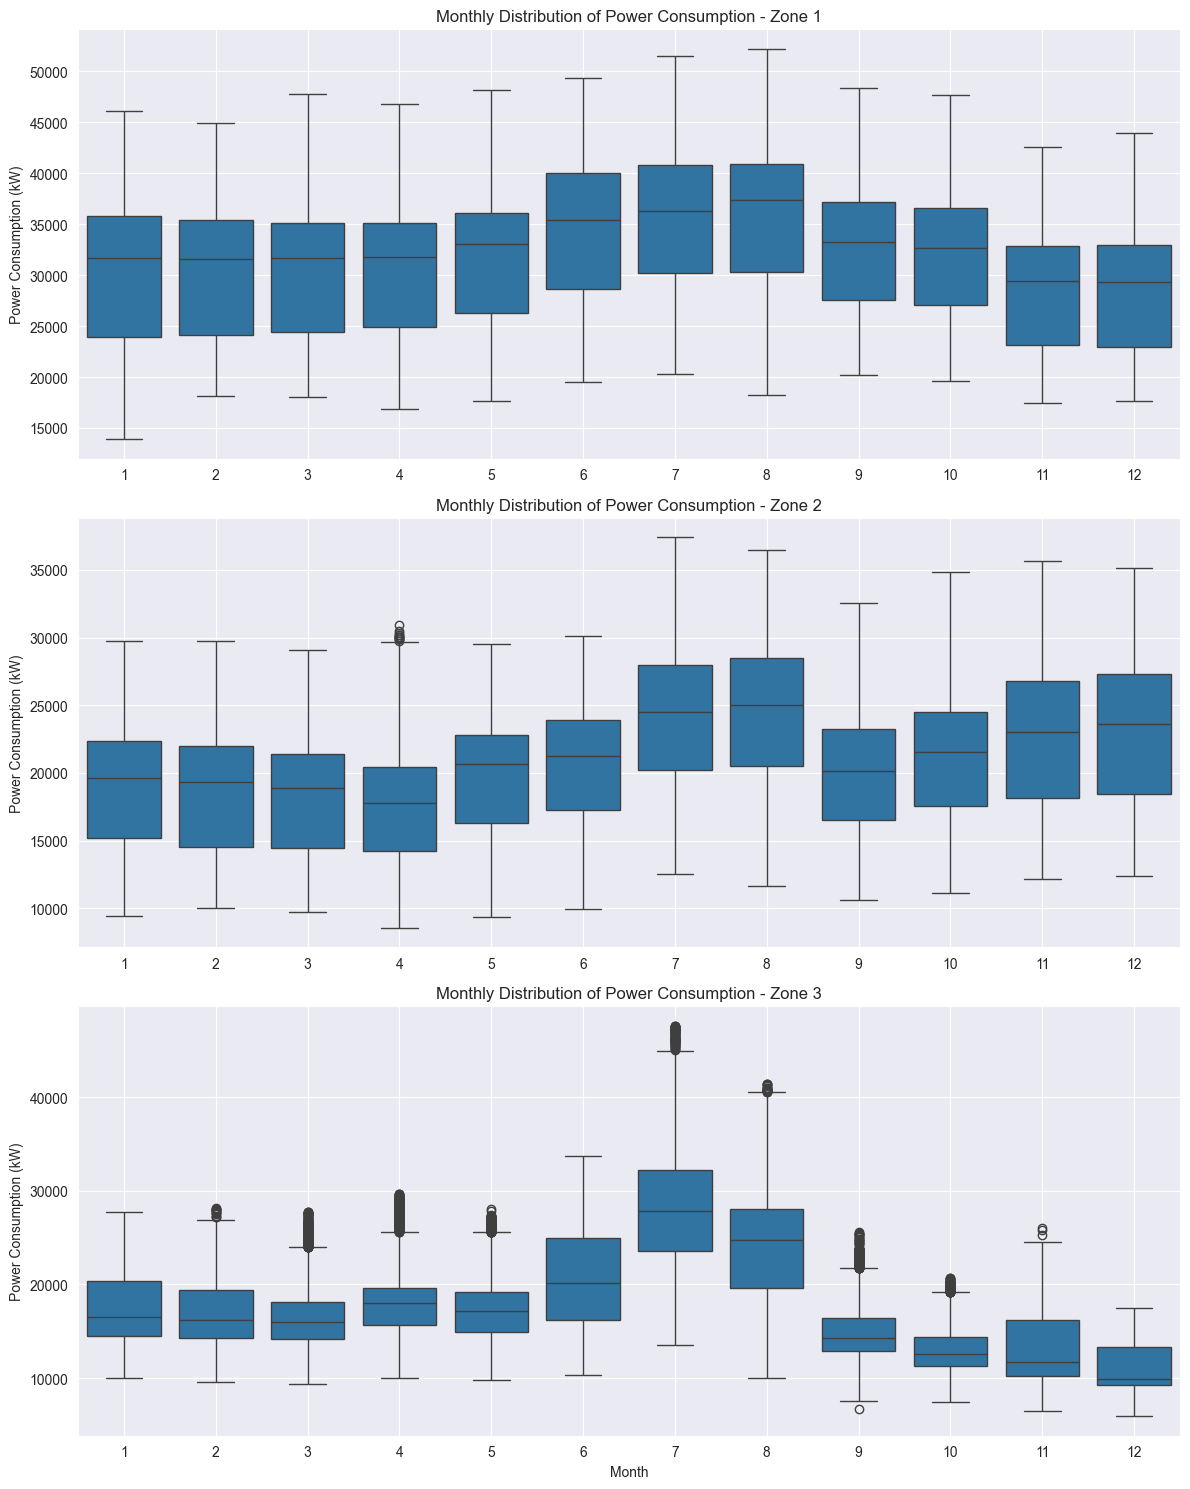

In [16]:
# Monthly distribution with box plots for all zones
power_df['Month'] = power_df.index.month
zones = ['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']

fig, axes = plt.subplots(3, 1, figsize=(12, 15))
for i, zone in enumerate(zones):
    sns.boxplot(data=power_df, x='Month', y=zone, ax=axes[i])
    axes[i].set_title(f'Monthly Distribution of Power Consumption - Zone {i+1}')
    axes[i].set_xlabel('Month' if i == 2 else '')  # Only show x-label for bottom plot
    axes[i].set_ylabel('Power Consumption (kW)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Key Insights:
- **Summer Peak**: All zones show highest consumption June-September.
- **Winter Trough**: Lowest consumption December-February.
- **Variability**:
  * Zone 3: Highest month-to-month variation.
  * Zone 1: Most consistent monthly pattern.
  * Zone 2: Moderate seasonal fluctuations.
- **Outliers**: More frequent extreme values during summer months, especially in Zone 3.

### <a id='toc4_'></a>[Feature Correlations](#toc0_)

We now examine the relationships between environmental features and power consumption across zones.

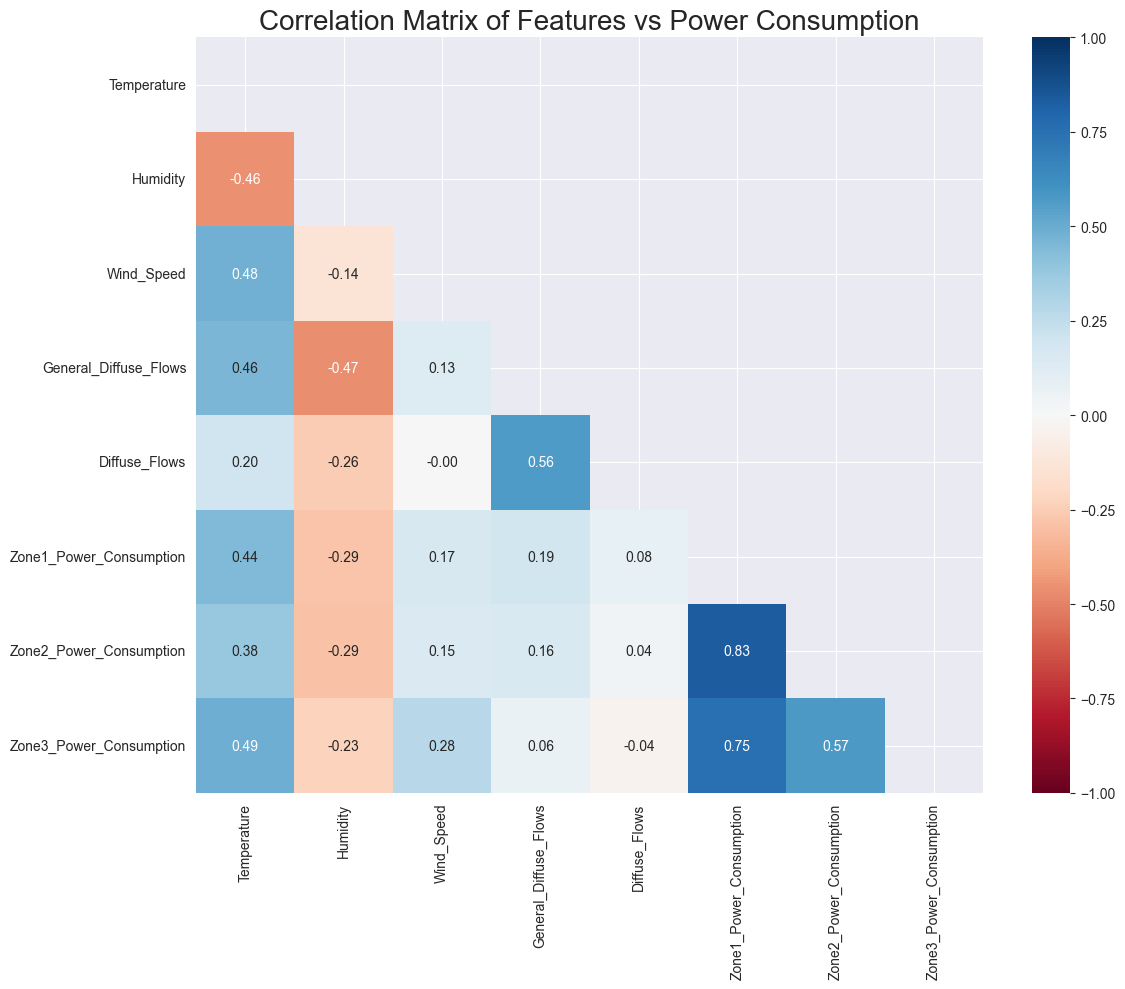


Correlations with Power Consumption:

Zone1_Power_Consumption:
Temperature              0.440221
General_Diffuse_Flows    0.187965
Wind_Speed               0.167444
Diffuse_Flows            0.080274
Humidity                -0.287421
Name: Zone1_Power_Consumption, dtype: float64

Zone2_Power_Consumption:
Temperature              0.382428
General_Diffuse_Flows    0.157223
Wind_Speed               0.146413
Diffuse_Flows            0.044667
Humidity                -0.294961
Name: Zone2_Power_Consumption, dtype: float64

Zone3_Power_Consumption:
Temperature              0.489527
Wind_Speed               0.278641
General_Diffuse_Flows    0.063376
Diffuse_Flows           -0.038506
Humidity                -0.233022
Name: Zone3_Power_Consumption, dtype: float64


In [17]:
# Define zones for correlation analysis
zones = ['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']

# Extract features excluding zones
features = power_df.drop(columns=zones+['DayOfWeek','Month','Hour']).columns.tolist()

# Create correlation matrix
corr_matrix = power_df[features + zones].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix))  

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True,
            mask=mask,
            cmap='RdBu',
            vmin=-1, vmax=1,
            center=0,
            fmt='.2f')
plt.title('Correlation Matrix of Features vs Power Consumption',fontsize=20)
plt.tight_layout()
plt.show()

# Display correlations with zones specifically
print("\nCorrelations with Power Consumption:")
for zone in zones:
    print(f"\n{zone}:")
    correlations = corr_matrix[zone][features].sort_values(ascending=False)
    print(correlations)

The correlation analysis reveals several key relationships between features and power consumption:

2. **Temperature Impact**:
   - Strong positive correlation with all zones (0.3-0.5).
   - Highest impact on Zone 3 consumption.
   - Confirms seasonal patterns observed in temporal analysis.

3. **Solar Radiation Factors**:
   - Weak correlations with General_Diffuse_Flows (0.05-0.2).
   - Similar correlation patterns across all zones.
   - Indicates solar radiation's role in power demand.

4. **Wind and Humidity**:
   - Weak positive correlations with Wind_Speed (0.1 to 0.3).
   - Moderate negative correlations with Humidity (-0.2 to -0.3).

5. **Zone-wise Differences**:
   - Zone 3's stronger correlations suggest higher sensitivity to environmental factors.
   - Different building types or land use patterns across zones may explain varying responses.
   - Industrial vs residential composition of zones likely influences environmental dependencies.

We will now visualize the relationships between environmental features and power consumption using scatter plots.

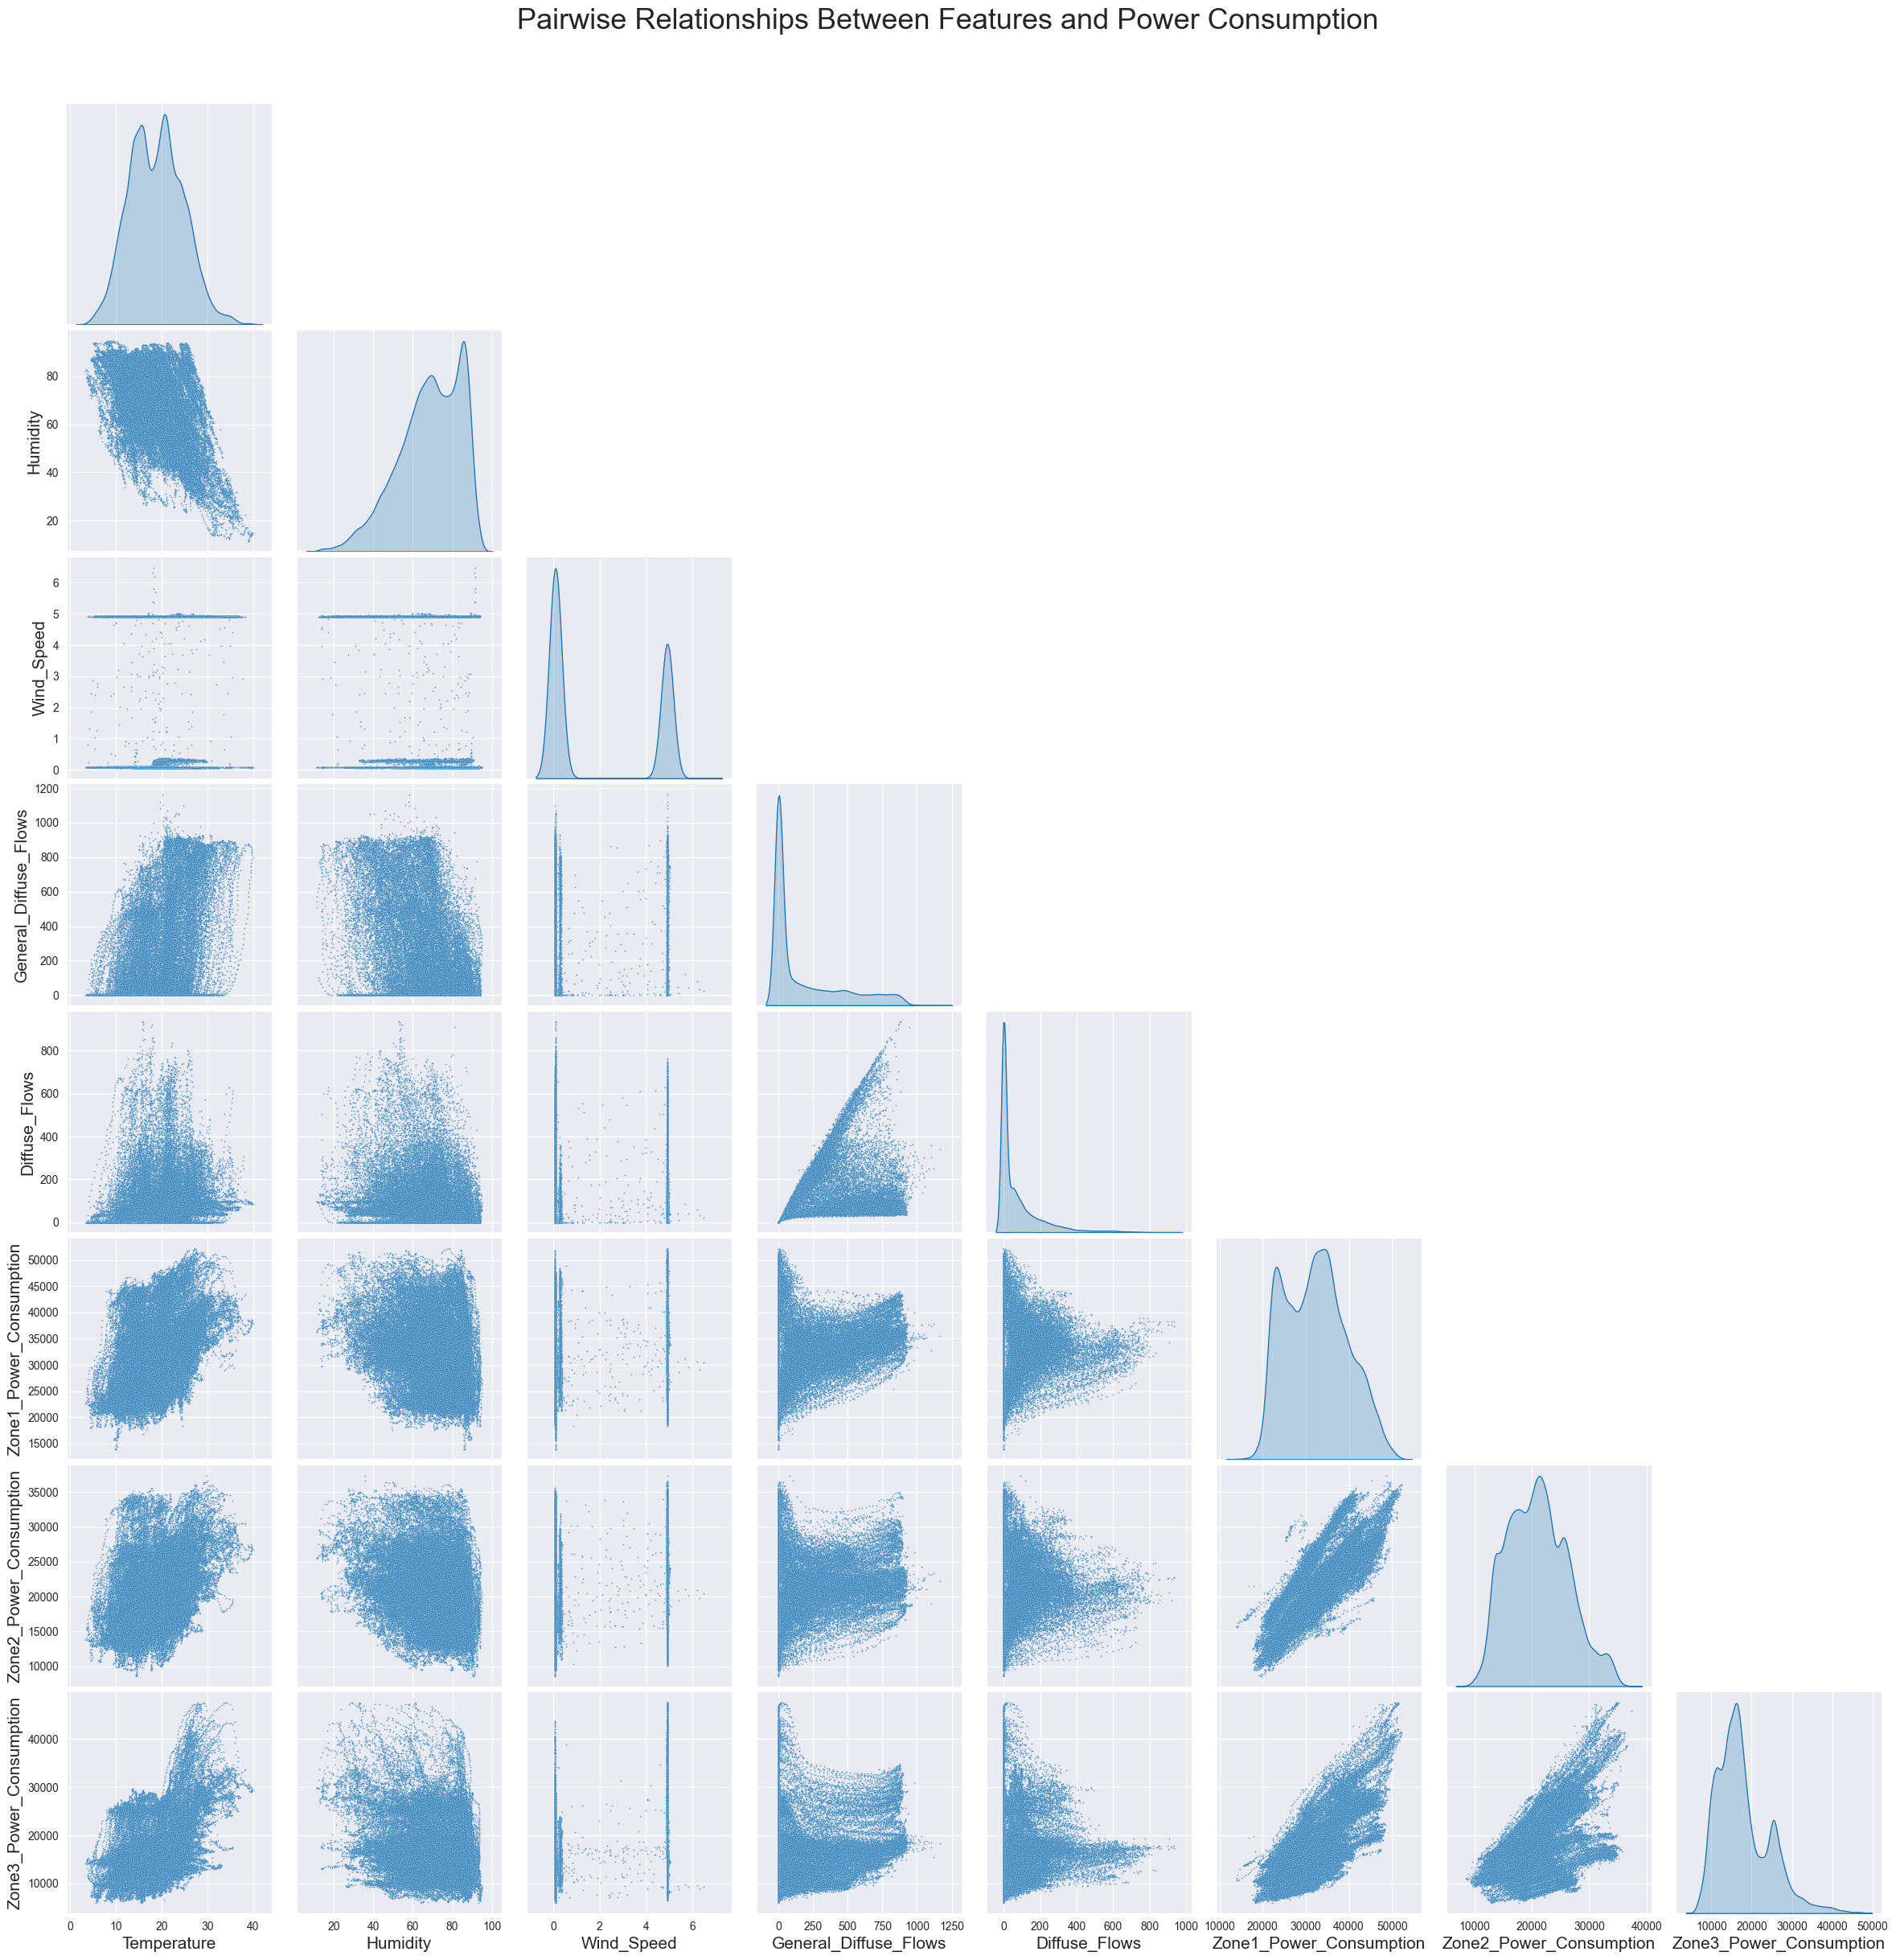

In [18]:
# Create pairplot with environmental features and power consumption
g = sns.pairplot(data=power_df,
             vars=features + zones,
             diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 2},
             corner=True,
             height=3)
plt.suptitle('Pairwise Relationships Between Features and Power Consumption', fontsize=26,y=1.02)

for ax in g.axes.flat:
    if ax is not None:  # Check if subplot exists
        # Increase label sizes
        ax.set_xlabel(ax.get_xlabel(), fontsize=15)
        ax.set_ylabel(ax.get_ylabel(), fontsize=15)
g.tight_layout()
plt.show()

Key Insights:

1. **Temperature Relationships**:
   - Clear positive trend between Temperature and power consumption across all zones.
   - Strongest relationship visible with Zone 3, confirming the higher correlation coefficient.
   - Non-linear patterns suggest temperature effects may be more complex than linear correlations indicate.

2. **Solar Radiation Patterns**:
   - Scattered relationships with General_Diffuse_Flows and Diffuse_Flows.
   - Weak but visible positive trends, matching the low correlation coefficients.
   - Higher variability in the relationship suggests other factors influence power consumption.

3. **Weather Variable Effects**:
   - Humidity shows slight negative trends with consumption.
   - Wind Speed relationships appear weak and scattered.


### <a id='toc5_'></a>[Outlier Analysis](#toc0_)

In this section, we identify and understand anomalies in weather and power consumption data to guide preprocessing for time series modeling.

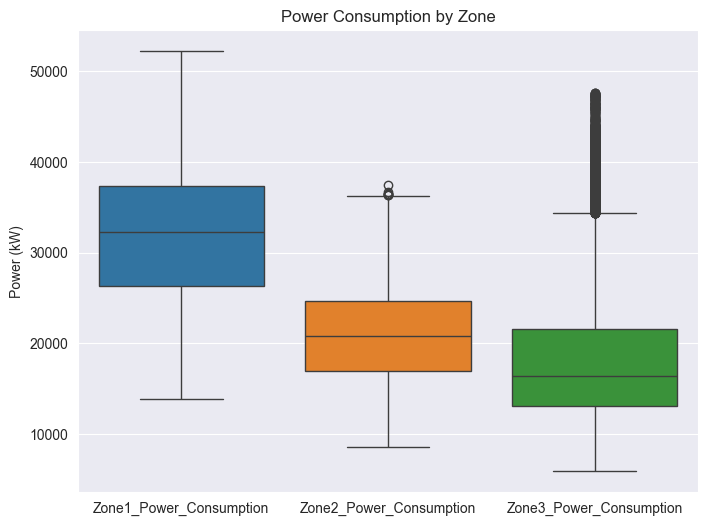

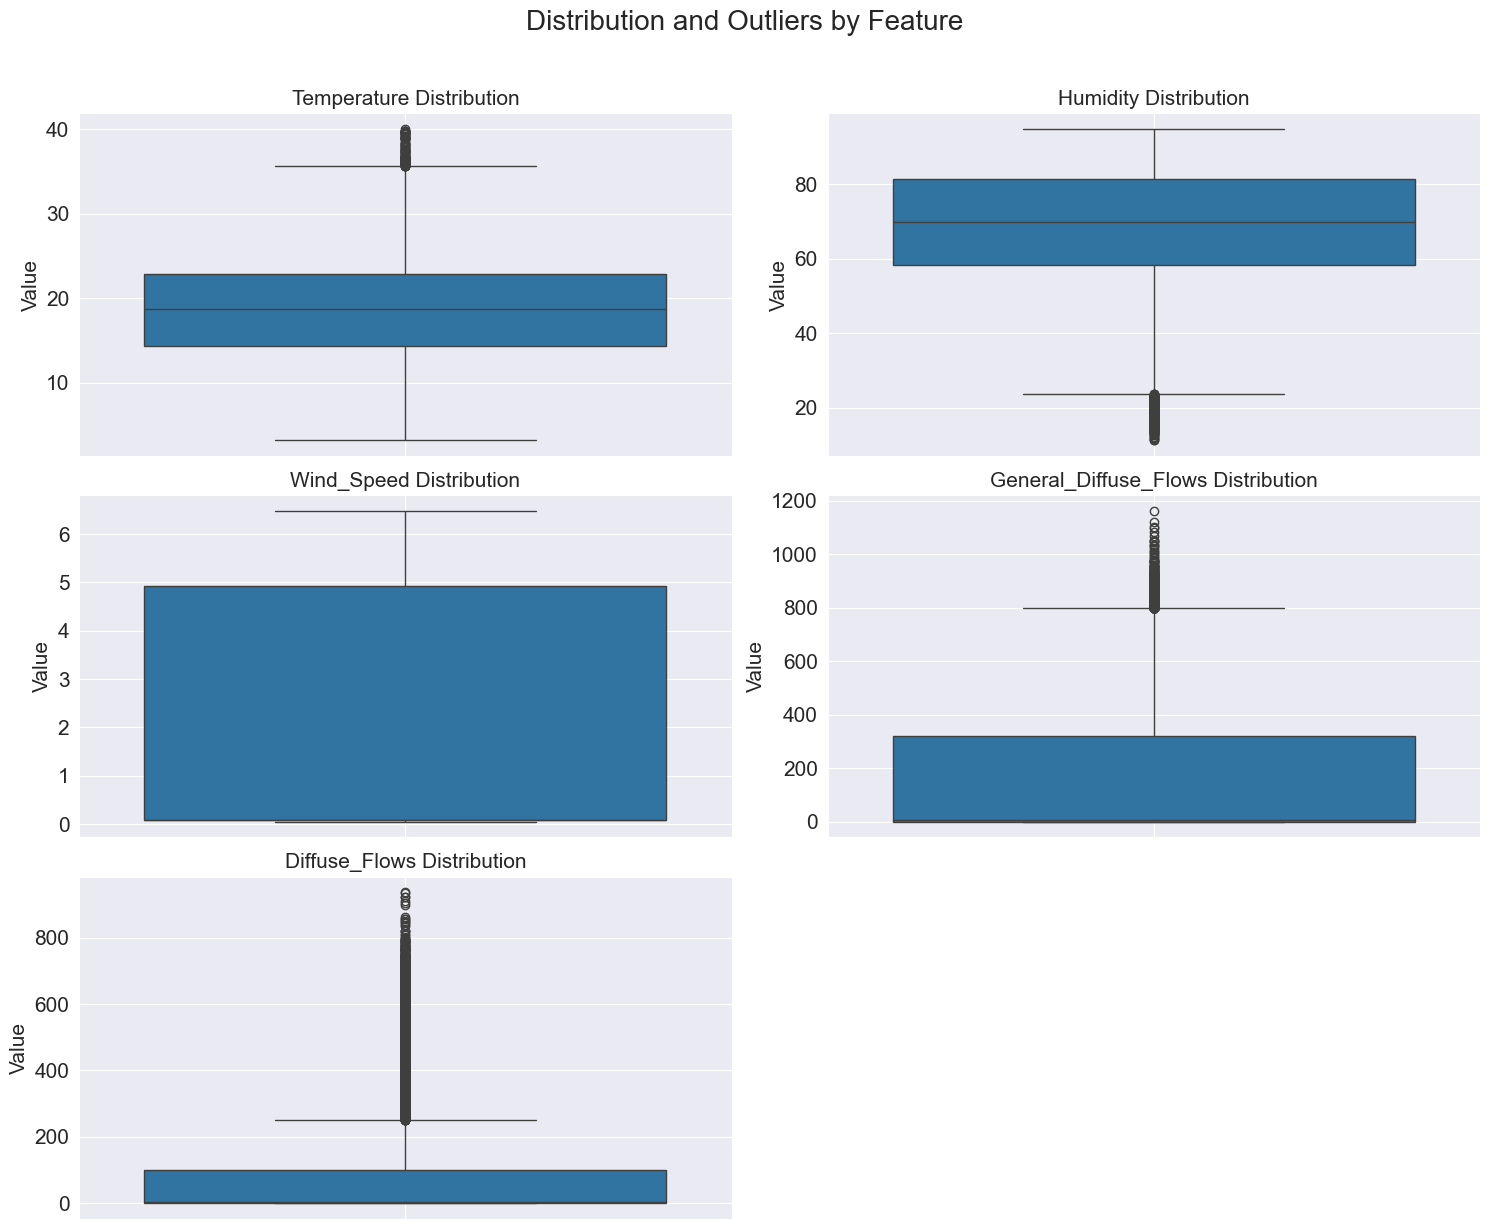


Power Consumption Zones Outlier Summary:

Zone1_Power_Consumption:
Number of outliers: 0
Percentage of outliers: 0.00%
IQR (Interquartile Range): 10998.35

Zone2_Power_Consumption:
Number of outliers: 7
Percentage of outliers: 0.01%
IQR (Interquartile Range): 7732.95

Zone3_Power_Consumption:
Number of outliers: 1191
Percentage of outliers: 2.27%
IQR (Interquartile Range): 8494.77

Weather Features Outlier Summary:

Temperature:
Number of outliers: 142
Percentage of outliers: 0.27%
IQR (Interquartile Range): 8.48

Humidity:
Number of outliers: 291
Percentage of outliers: 0.56%
IQR (Interquartile Range): 23.09

Wind_Speed:
Number of outliers: 0
Percentage of outliers: 0.00%
IQR (Interquartile Range): 4.84

General_Diffuse_Flows:
Number of outliers: 2315
Percentage of outliers: 4.42%
IQR (Interquartile Range): 319.54

Diffuse_Flows:
Number of outliers: 4571
Percentage of outliers: 8.72%
IQR (Interquartile Range): 100.88


In [19]:
# Define features and target variables
zones = ['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']
weather_features = ['Temperature', 'Humidity', 'Wind_Speed', 'General_Diffuse_Flows', 'Diffuse_Flows']

# Plot power consumption zones
sns.boxplot(data=power_df[zones])
plt.title('Power Consumption by Zone')
plt.ylabel('Power (kW)')

# Calculate number of rows needed for 2 columns
n_rows = (len(weather_features) + 1) // 2  # Ceiling division

# Create subplots in 2-column grid
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 4*n_rows))
fig.suptitle('Distribution and Outliers by Feature', fontsize=20, y=1.02)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Create individual boxplots
for idx, feature in enumerate(weather_features):
    sns.boxplot(data=power_df[feature], ax=axes[idx])
    axes[idx].set_title(f'{feature} Distribution',fontsize=15)
    axes[idx].set_ylabel('Value',fontsize=15)
    axes[idx].tick_params(axis='both', labelsize=15)
    axes[idx].grid(True)

# Hide empty subplot if odd number of features
if len(weather_features) % 2 != 0:
    axes[-1].remove()

plt.tight_layout()
plt.show()


# Print summary statistics
print("\nPower Consumption Zones Outlier Summary:")
for zone in zones:
    Q1 = power_df[zone].quantile(0.25)
    Q3 = power_df[zone].quantile(0.75)
    IQR = Q3 - Q1
    outliers = power_df[(power_df[zone] < Q1 - 1.5*IQR) | (power_df[zone] > Q3 + 1.5*IQR)][zone]
    print(f"\n{zone}:")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {(len(outliers)/len(power_df)*100):.2f}%")
    print(f"IQR (Interquartile Range): {IQR:.2f}")

print("\nWeather Features Outlier Summary:")
for feature in weather_features:
    Q1 = power_df[feature].quantile(0.25)
    Q3 = power_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = power_df[(power_df[feature] < Q1 - 1.5*IQR) | (power_df[feature] > Q3 + 1.5*IQR)][feature]
    print(f"\n{feature}:")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {(len(outliers)/len(power_df)*100):.2f}%")
    print(f"IQR (Interquartile Range): {IQR:.2f}")

Key Insights:

**Power Consumption:**  
- **Zone 1:** No outliers, widest IQR — stable and consistent usage.  
- **Zone 2:** Very few outliers (0.01%), smallest IQR — compact and controlled consumption.  
- **Zone 3:** Significant outliers (2.27%), moderate IQR — high variability with extreme values.  

**Weather Features:**  
- **Temperature:** Few outliers (0.27%), symmetric and seasonal range.  
- **Humidity:** Moderate outliers (0.56%), wide IQR, likely right-skewed.  
- **Wind Speed:** No outliers, tight IQR — consistent low variation.  
- **Diffuse Flows:** Many outliers in both General (4.4%) and Diffuse (8.7%) flows, strong right skew likely driven by daylight patterns and atmospheric variability.



Now we will investigate and visualize the detected outliers. This step will help us decide whether these outliers should be removed, transformed, or retained for further analysis.

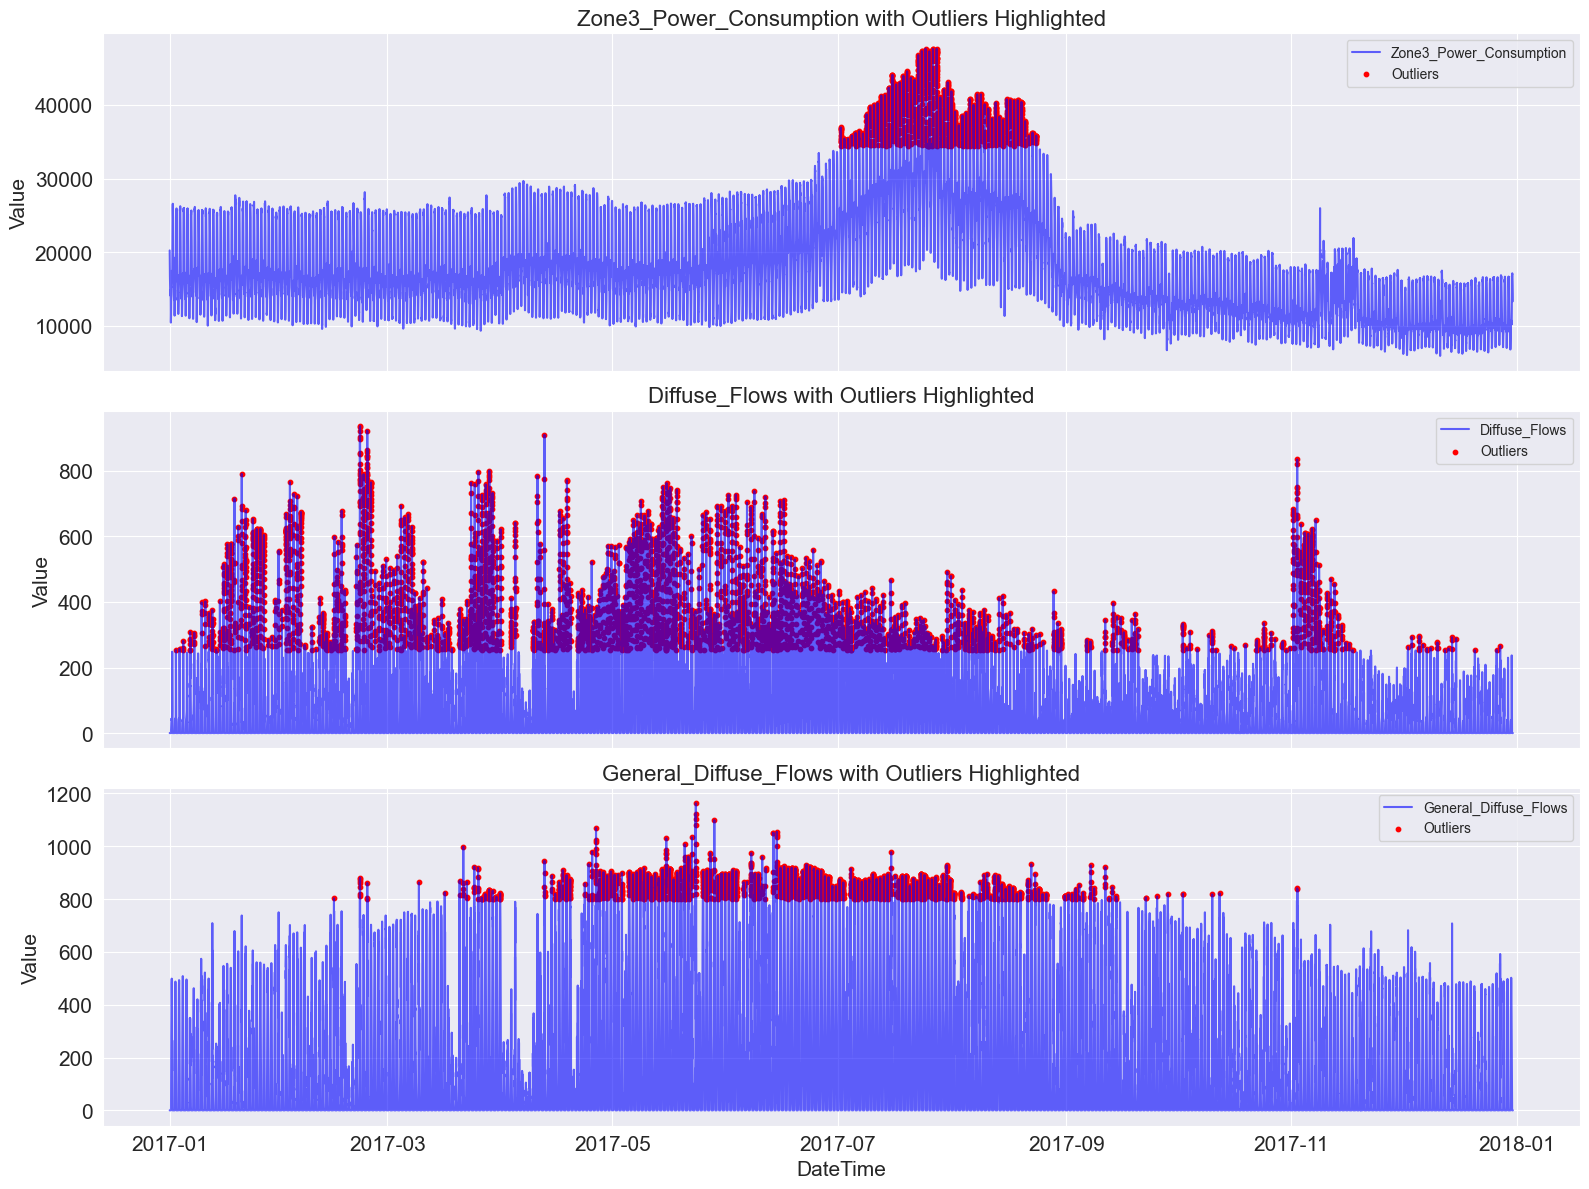

In [20]:
# Visualize outliers over time for Zone3_Power_Consumption, Diffuse_Flows, and General_Diffuse_Flows

features_to_plot = ['Zone3_Power_Consumption', 'Diffuse_Flows', 'General_Diffuse_Flows']

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
for idx, feature in enumerate(features_to_plot):
    Q1 = power_df[feature].quantile(0.25)
    Q3 = power_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (power_df[feature] < lower_bound) | (power_df[feature] > upper_bound)
    
    axes[idx].plot(power_df.index, power_df[feature], label=f'{feature}', color='blue', alpha=0.6)
    axes[idx].scatter(power_df.index[outlier_mask], power_df[feature][outlier_mask], 
                      color='red', label='Outliers', s=10)
    axes[idx].set_title(f'{feature} with Outliers Highlighted', fontsize=16)
    axes[idx].set_ylabel('Value', fontsize=15)
    axes[idx].tick_params(axis='both', labelsize=15)
    axes[idx].legend()
    axes[idx].grid(True)

axes[-1].set_xlabel('DateTime', fontsize=15)
plt.tight_layout()
plt.show()

Key Insights:

- The outliers detected in **Zone 3 Power Consumption** appear to be genuine reflections of increased demand during summer months and are a part of the underlying seasonal component of the dataset. Therefore, these outliers should not be removed, as they represent important real-world patterns.

- To address the skewness and reduce the influence of extreme values in weather variables - General Diffuse Flows/ Diffuse Flows, we apply a **log transformation** to these features. This helps stabilize variance, normalize distributions, and improve the robustness of downstream modeling.

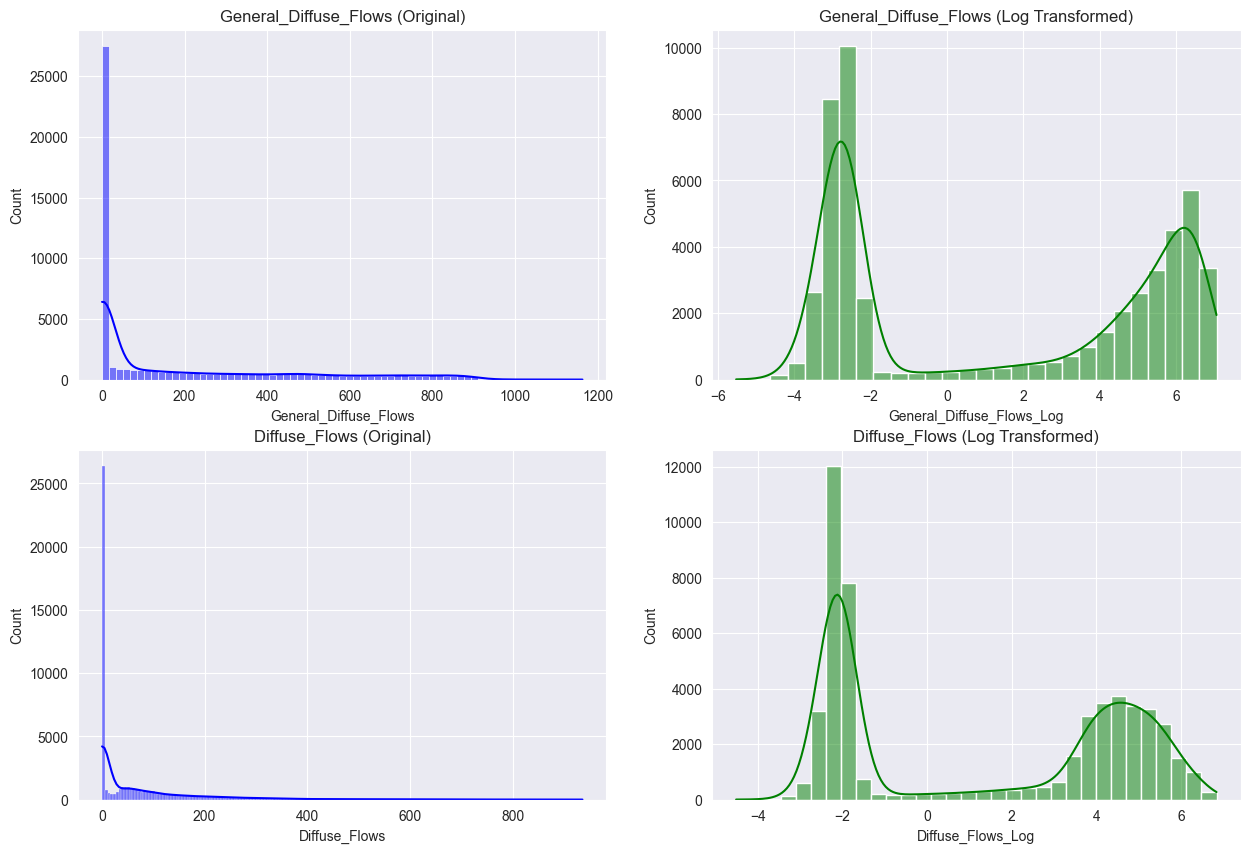

In [22]:
# Apply and visualize original, log-transformed distributions for General_Diffuse_Flows and Diffuse_Flows

for feature in ['General_Diffuse_Flows', 'Diffuse_Flows']:
    offset=0  # no need of any offset due to strictly positive values in the column  
    power_df[f'{feature}_Log'] = np.log(power_df[feature] + offset)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
features = ['General_Diffuse_Flows', 'Diffuse_Flows']
titles = ['Original', 'Log Transformed']

for row, feature in enumerate(features):
    # Original
    sns.histplot(power_df[feature], ax=axes[row, 0], kde=True, color='blue')
    axes[row, 0].set_title(f'{feature} ({titles[0]})')
    # Log
    sns.histplot(power_df[f'{feature}_Log'], ax=axes[row, 1], kde=True, color='green')
    axes[row, 1].set_title(f'{feature} ({titles[1]})')

for ax in axes.flat:
    ax.set_ylabel('Count')

In [23]:
# Check outliers after Log transformation for General_Diffuse_Flows and Diffuse_Flows

for feature in ['General_Diffuse_Flows_Log', 'Diffuse_Flows_Log']:
    Q1 = power_df[feature].quantile(0.25)
    Q3 = power_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = power_df[(power_df[feature] < lower_bound) | (power_df[feature] > upper_bound)][feature]
    print(f"\n{feature} Outlier Summary:")
    print(f"IQR: {IQR:.2f}")
    print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"Percentage of outliers: {(len(outliers)/len(power_df)*100):.2f}%")


General_Diffuse_Flows_Log Outlier Summary:
IQR: 8.55
Lower bound: -15.60, Upper bound: 18.59
Percentage of outliers: 0.00%

Diffuse_Flows_Log Outlier Summary:
IQR: 6.72
Lower bound: -12.18, Upper bound: 14.69
Percentage of outliers: 0.00%


### <a id='toc6_'></a>[Time Series Decomposition](#toc0_)

This section performs a time series decomposition of daily power consumption to uncover underlying patterns. Each zone is analyzed individually to compare their temporal structures and highlight how different area types exhibit distinct consumption behaviors.

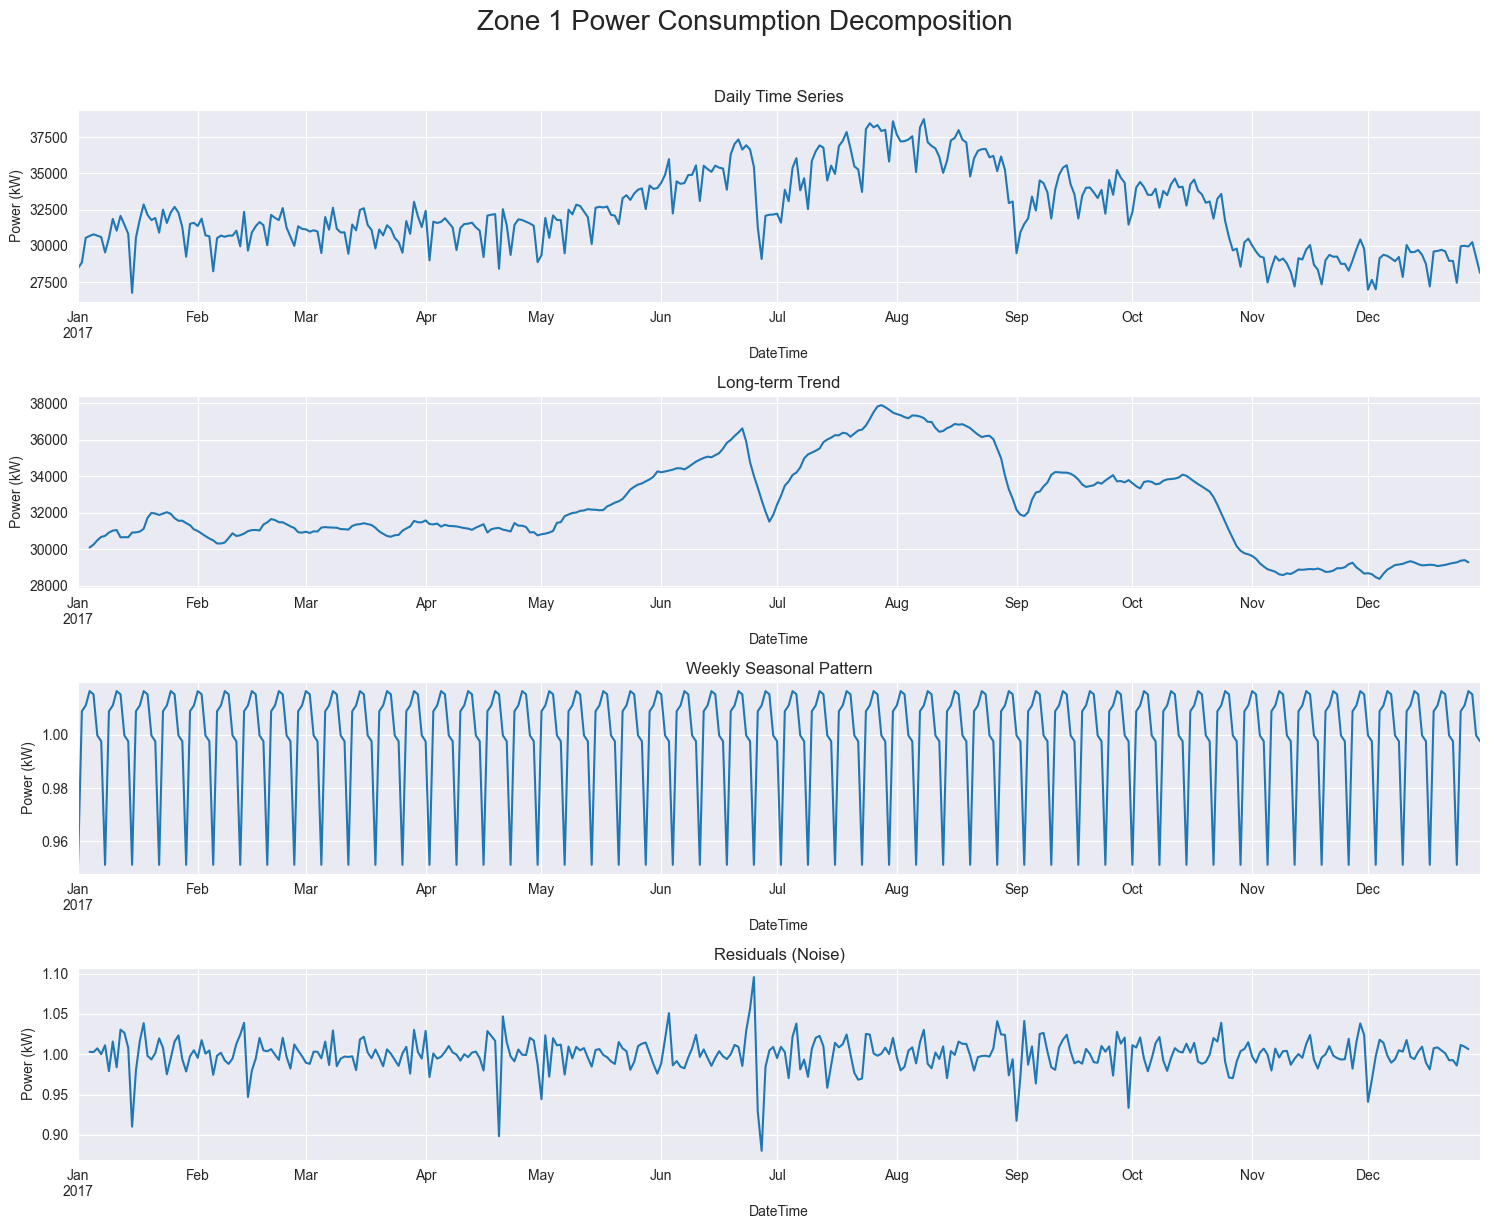

In [24]:
# Resample to daily frequency and calculate mean
power_daily = power_df.resample('D').mean()

# Extract single series for decomposition
zone1_daily = power_daily['Zone1_Power_Consumption']

# Perform seasonal decomposition with weekly seasonality
decomposition = tsa.seasonal_decompose(zone1_daily, 
                                     model='multiplicative',
                                     period=7)  # 7 days for weekly seasonality

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Daily series
zone1_daily.plot(ax=ax1)
ax1.set_title('Daily Time Series')
ax1.set_ylabel('Power (kW)')

# Trend component
decomposition.trend.plot(ax=ax2)
ax2.set_title('Long-term Trend')
ax2.set_ylabel('Power (kW)')

# Seasonal component
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Weekly Seasonal Pattern')
ax3.set_ylabel('Power (kW)')

# Residuals
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals (Noise)')
ax4.set_ylabel('Power (kW)')

plt.suptitle('Zone 1 Power Consumption Decomposition', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

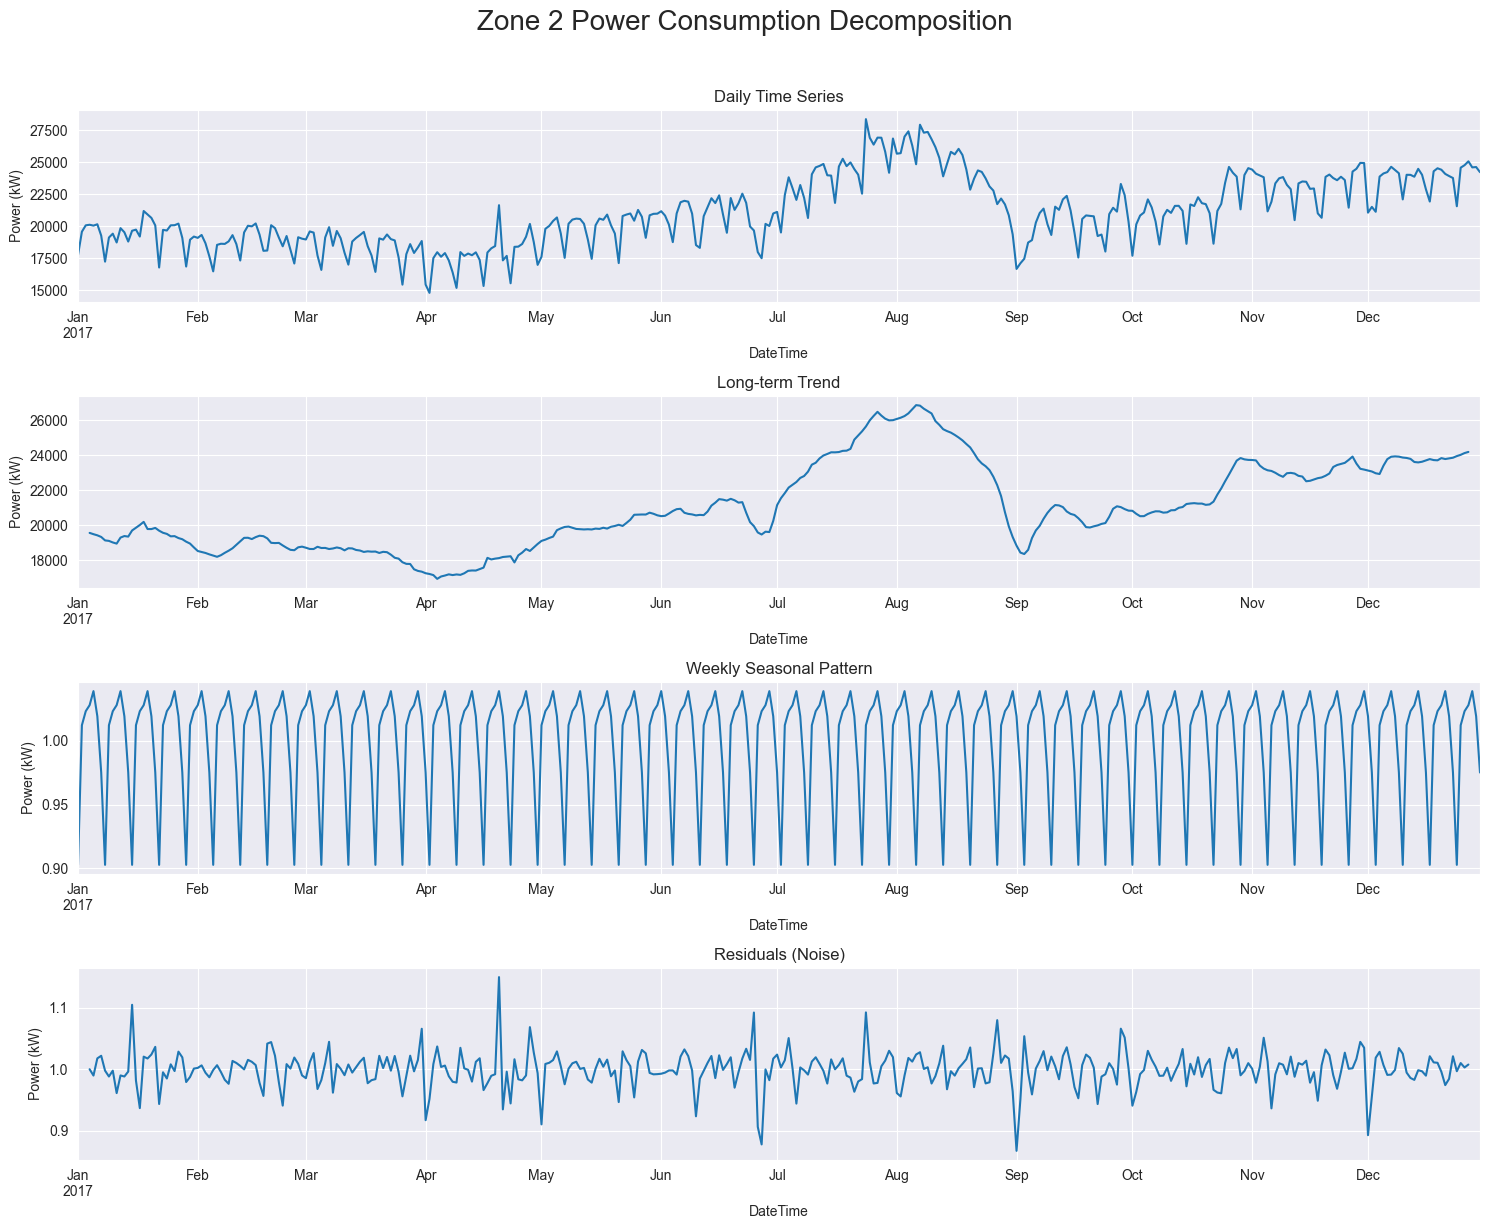

In [25]:
# Zone 2 Power Decomposition

# Extract series for decomposition
zone2_daily = power_daily['Zone2_Power_Consumption']

# Perform seasonal decomposition with weekly seasonality
decomposition = tsa.seasonal_decompose(zone2_daily, 
                                     model='multiplicative',
                                     period=7)  # 7 days for weekly seasonality

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Daily series
zone2_daily.plot(ax=ax1)
ax1.set_title('Daily Time Series')
ax1.set_ylabel('Power (kW)')

# Trend component
decomposition.trend.plot(ax=ax2)
ax2.set_title('Long-term Trend')
ax2.set_ylabel('Power (kW)')

# Seasonal component
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Weekly Seasonal Pattern')
ax3.set_ylabel('Power (kW)')

# Residuals
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals (Noise)')
ax4.set_ylabel('Power (kW)')

plt.suptitle('Zone 2 Power Consumption Decomposition', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

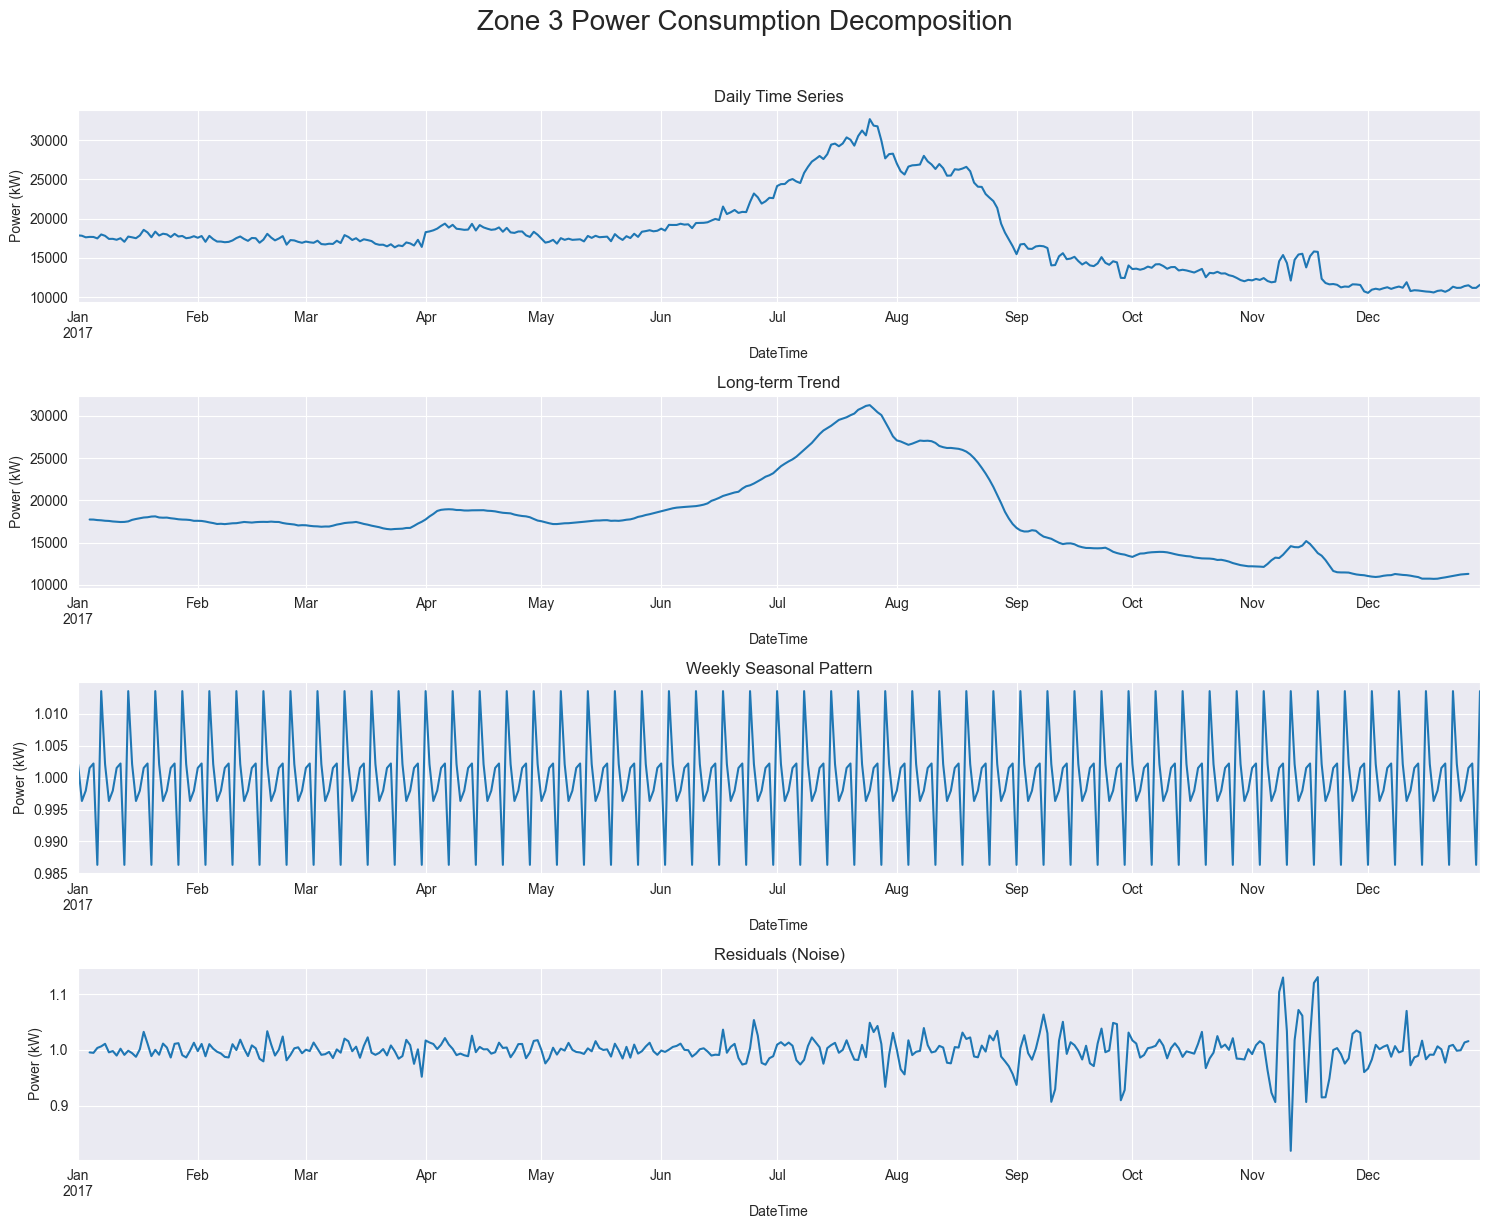

In [26]:
# Zone 3 Power Decomposition

# Extract series for decomposition
zone3_daily = power_daily['Zone3_Power_Consumption']

# Perform seasonal decomposition with weekly seasonality
decomposition = tsa.seasonal_decompose(zone3_daily, 
                                     model='multiplicative',
                                     period=7)  # 7 days for weekly seasonality

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Daily series
zone3_daily.plot(ax=ax1)
ax1.set_title('Daily Time Series')
ax1.set_ylabel('Power (kW)')

# Trend component
decomposition.trend.plot(ax=ax2)
ax2.set_title('Long-term Trend')
ax2.set_ylabel('Power (kW)')

# Seasonal component
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Weekly Seasonal Pattern')
ax3.set_ylabel('Power (kW)')

# Residuals
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals (Noise)')
ax4.set_ylabel('Power (kW)')

plt.suptitle('Zone 3 Power Consumption Decomposition', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

We choose a multiplicative model for seasonal decomposition because 
- Seasonal variations increase with the level of the series.
- Variance of fluctuations grows with the mean level.
- Summer peaks show proportionally larger variations.
- Residuals show better homoscedasticity compared to additive model.

Key Insights from time series decomposition of power consumption within three zones:

1. **Zone 1**:
   - Most stable consumption pattern with moderate seasonal fluctuations reflecting residential usage patterns.
   - Clear weekly cycles.
   - Relatively smaller summer peaks compared to other zones.
   - Most consistent residual patterns suggesting predictable behavior.

2. **Zone 2**:
   - Intermediate variability in both trend and seasonal components reflecting mixed commercial/residential use.
   - Strong weekday/weekend patterns.
   - Moderate summer peaks and winter troughs.
   - Mixed residual patterns reflecting diverse usage types.

3. **Zone 3**:
   - Highest overall variability and strongest seasonal effects.
   - Sharp drops occur regularly every Saturday-Sunday suggesting strong industrial/commercial activity during weekdays.
   - Pronounced summer peaks indicating heavy cooling demand.
   - Some outliers visible, particularly during peak consumption periods.

### <a id='toc7_'></a>[Lag Effects](#toc0_)

This section examines how past weather conditions influence current power consumption by analyzing cross-correlation with environmental features at different time lags. Understanding these lag effects can help improve forecasting accuracy and guide feature engineering for time-series modeling.

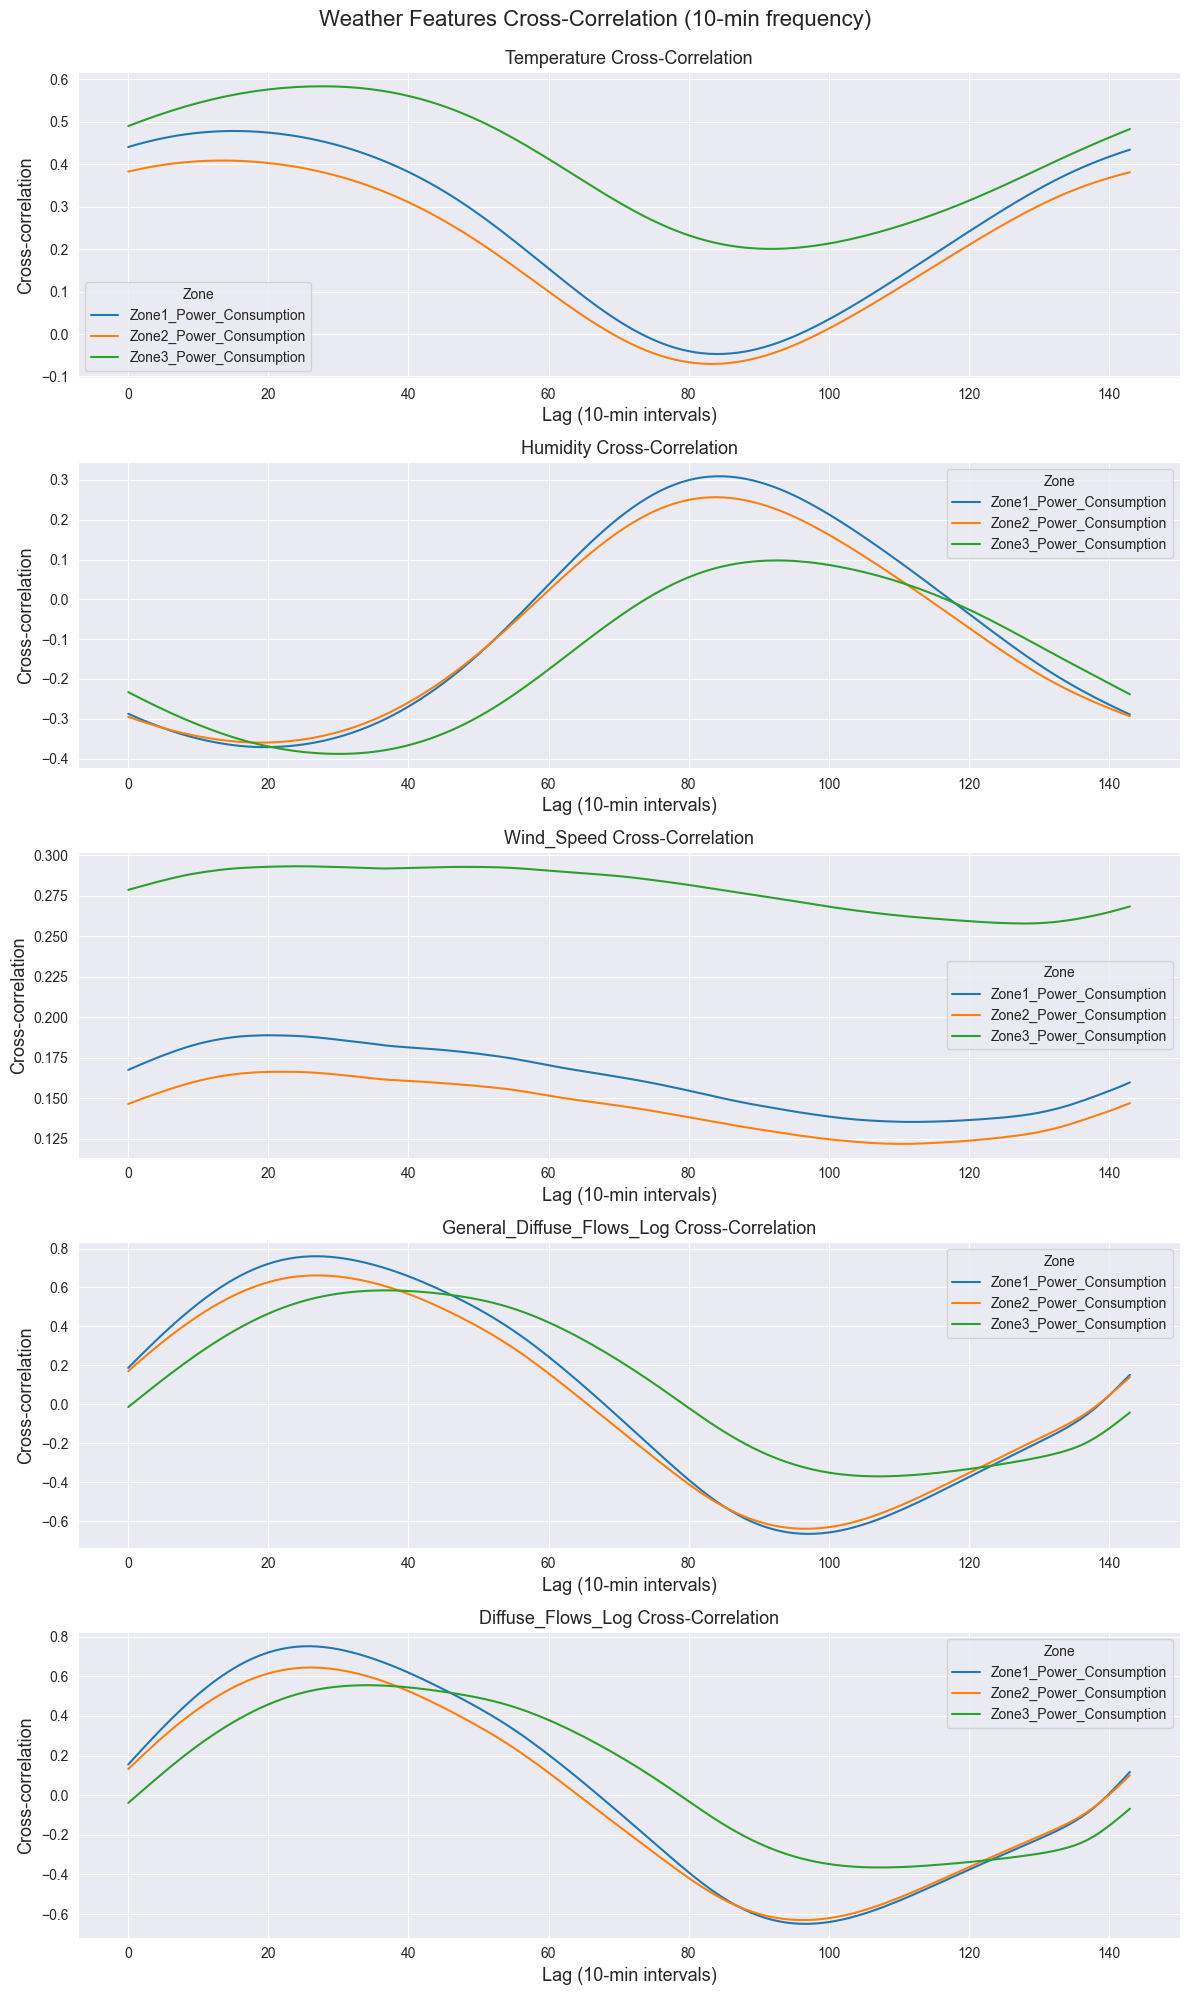

In [31]:
# Define parameters for high-frequency analysis
max_lags_10min = 144  # 24 hours in 10-minute intervals
zones = ['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']
weather_features = ['Temperature', 'Humidity', 'Wind_Speed', 'General_Diffuse_Flows_Log', 'Diffuse_Flows_Log']

# Create subplots for cross-correlation analysis at 10-min frequency
fig, axes = plt.subplots(len(weather_features), 1, figsize=(12, 4*len(weather_features)))
fig.suptitle('Weather Features Cross-Correlation (10-min frequency)', fontsize=16, y=0.995)

for idx, feature in enumerate(weather_features):
    lag_corrs = pd.DataFrame()
    
    for zone in zones:
        # Calculate cross-correlation at 10-min frequency
        xcorr = tsa.stattools.ccf(power_df[zone], 
                                    power_df[feature], 
                                    unbiased=True)[:max_lags_10min]
        lag_corrs[zone] = xcorr
    
    # Plot cross-correlations
    lag_corrs.plot(ax=axes[idx])
    axes[idx].set_title(f'{feature} Cross-Correlation',fontsize=13)
    axes[idx].set_xlabel('Lag (10-min intervals)',fontsize=13)
    axes[idx].set_ylabel('Cross-correlation',fontsize=13)
    axes[idx].legend(title='Zone')
    axes[idx].grid(True)    

plt.tight_layout()
plt.show()


Key Insights

1. **Temperature Cross-Correlations**:
   - Strong positive correlations (0.3-0.5) persist up to 6-8 hours.
   - Zone 3 shows strongest temperature dependence.
   - 24-hour cyclic pattern indicates daily temperature-consumption relationship.

2. **Humidity Cross-Correlations**:
   - Mixed, generally low to moderate correlations ranging from about +0.3 to -0.4 depending on lag and zone.
   - Zone 1 and 2 show positive smaller peaks around 70-90 lags (~12-15 hours), while Zone 3 shows weaker or slightly negative correlations at these lags.
   - Effects are more immediate compared to temperature.
   - Distinct cyclical pattern visible, but with different shapes across zones, suggesting a complex and zone-dependent relationship.

3. **Solar Radiation Patterns**:
   - Strong positive correlations peaking near 0.5-0.6 around 25-50 lags (~4-8 hours), followed by sharp decline into negative correlations around 80-100 lags.
   - Clear daily cycles in cross-correlation.
   - General_Diffuse_Flows show stronger relationships than Diffuse_Flows.

4. **Wind Speed Effects**:
   - Correlations are generally weak but positive, ranging from about 0.15-0.3 depending on zone.
   - Zone 3 shows consistently higher baseline.
   - Correlation remains relatively flat with little cyclical or lag-dependent structure, indicating more stable but low direct effects.

**Autocorrelation Effects**
   - Power consumption shows strong persistence (autocorrelation) across all zones, which can artificially inflate cross-correlation values.
   - Both power and weather features share strong daily and seasonal rhythms, complicating causal interpretation.
   - Cross-correlation results should be interpreted considering these confounding factors, especially at longer lags.


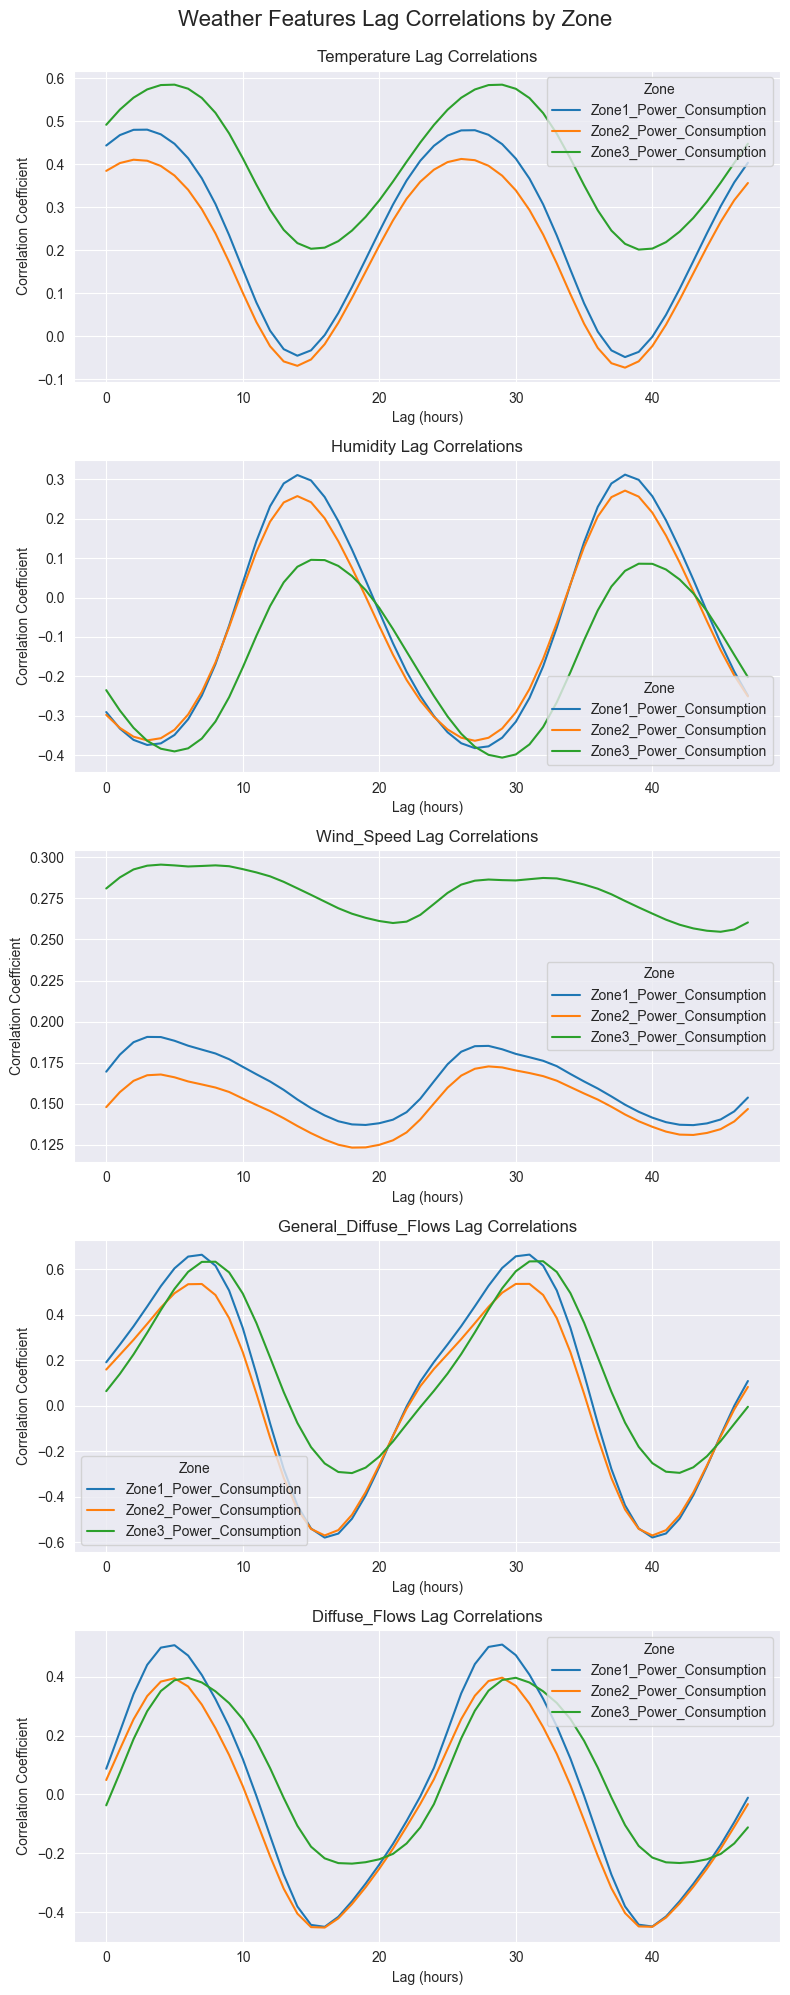

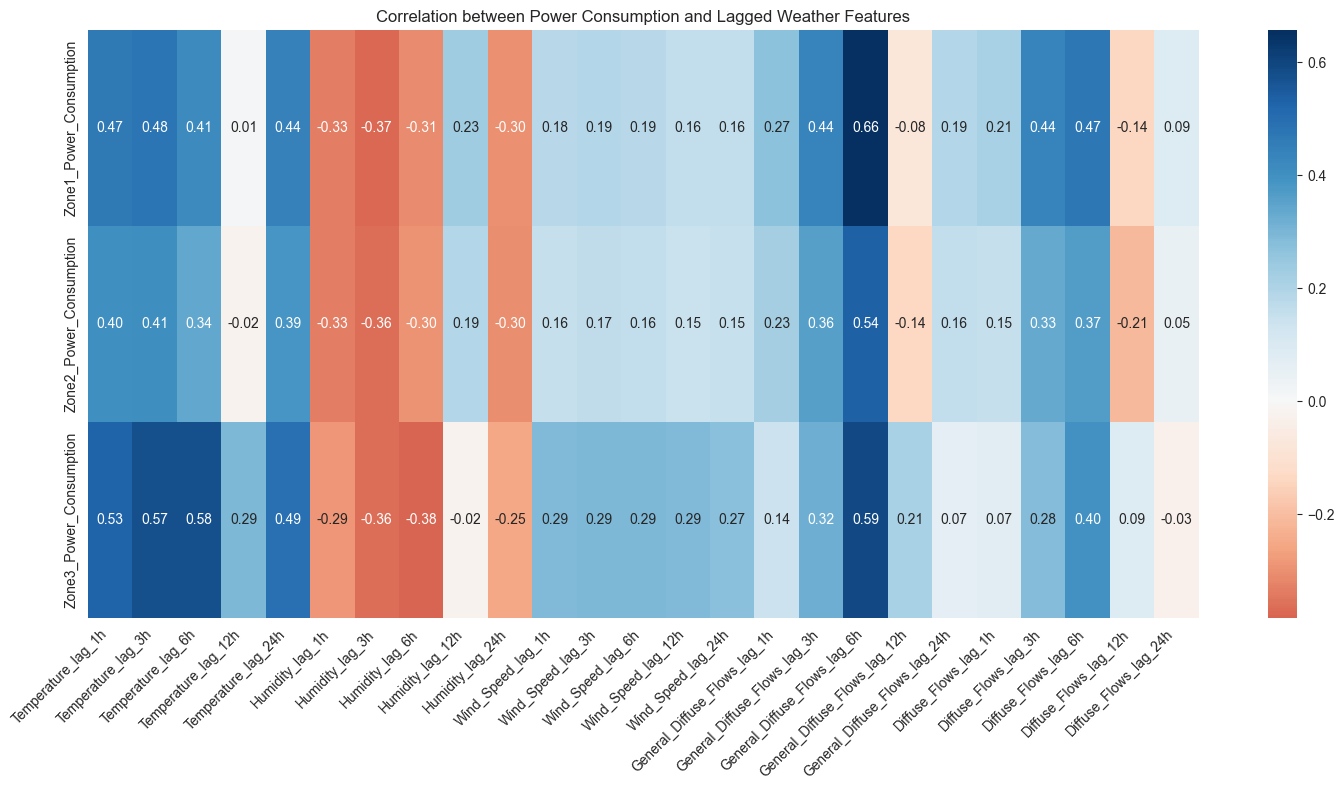

In [28]:
# Resample data to hourly frequency for lag analysis
hourly_data = power_df.resample('H').mean()

# Define features to analyze
weather_features = ['Temperature', 'Humidity', 'Wind_Speed', 'General_Diffuse_Flows', 'Diffuse_Flows']
max_lags = 48  # 2 days of hourly lags
zones = ['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']

# Create subplots for each feature
fig, axes = plt.subplots(len(weather_features), 1, figsize=(8, 4*len(weather_features)))
fig.suptitle('Weather Features Lag Correlations by Zone', fontsize=16, y=0.995)

for idx, feature in enumerate(weather_features):
    lag_corrs = pd.DataFrame()
    
    # Calculate lagged correlations for each zone
    for zone in zones:
        corrs = []
        for lag in range(max_lags):
            corr = hourly_data[zone].corr(hourly_data[feature].shift(lag))
            corrs.append(corr)
        lag_corrs[zone] = corrs
    
    # Plot on respective subplot
    lag_corrs.plot(ax=axes[idx])
    axes[idx].set_title(f'{feature} Lag Correlations')
    axes[idx].set_xlabel('Lag (hours)')
    axes[idx].set_ylabel('Correlation Coefficient')
    axes[idx].legend(title='Zone')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

# Create feature matrix with different lags
lag_features = weather_features
lags = [1, 3, 6, 12, 24]  # Different lag intervals to test

for feature in lag_features:
    for lag in lags:
        hourly_data[f'{feature}_lag_{lag}h'] = hourly_data[feature].shift(lag)

# Plot heatmap of lagged correlations
lag_cols = [col for col in hourly_data.columns if 'lag' in col]
corr_matrix = hourly_data[zones + lag_cols].corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix.loc[zones, lag_cols],
            annot=True,
            fmt='.2f',
            cmap='RdBu',
            center=0)
plt.title('Correlation between Power Consumption and Lagged Weather Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The lag effect analysis using hourly resampled data shows similar patterns to the original high-frequency (10-min) cross-correlation results:

- **Temperature:** Strong positive correlations with power consumption persist for several hours, especially in Zone 3, confirming daily cyclic effects.
- **Humidity:** Correlations remain low to moderate and show similar lag structures as before, with minor zone-dependent differences.
- **Solar Radiation (Diffuse Flows):** Positive correlations peak at short lags and decline at longer lags, mirroring the daily cycles seen in the raw data.
- **Wind Speed:** Weak, mostly positive correlations, consistent across both analyses.

Overall, the hourly resampling smooths out some noise but does not substantially change the main insights or relationships observed in the raw lag effect analysis.

### <a id='toc8_'></a>[Conclusion](#toc0_)

In this notebook, we performed a thorough exploratory data analysis of the Tetuan Power Consumption dataset, covering data cleaning, temporal and seasonal trend analysis, feature correlations, outlier detection and treatment, time series decomposition, and lag effect analysis. These insights provide a strong foundation for understanding the drivers of power consumption across zones. Next, we will proceed with feature engineering and prepare the dataset for modeling.